# ⚽ 2026 World Cup Readiness Framework - Exploratory Data Analysis

**Team:** XOH - SOOMI OH, YOO MI OH

**Date:** February 2026  

**For Executive Summary:** See `EDA_Executive.ipynb`

## Overview 
The 2026 FIFA World Cup, co-hosted across the United States, Canada, and Mexico, represents the largest edition of the tournament in history — 48 nations, three confederations of host advantage, and a genuinely open competitive landscape for the first time since the format expanded.

This report presents a data-driven framework for quantifying national team readiness ahead of that tournament. The central argument is simple: predicting World Cup performance requires more than ranking teams by FIFA rating or recent results. It requires understanding three distinct but interconnected questions simultaneously; who are the players, what kind of team do they form, and what contextual factors shape their tournament prospects.

To answer these questions, we built a three-layer analytical system grounded in StatsBomb open event data. Tournament-level team data from the 2022 World Cup and 2024 European Championship provides the tactical foundation - eight dimensions of collective behaviour that reveal how teams actually play, not how they are perceived to play. Player-level performance data spanning 2021 to 2025 across all competitions provides the individual quality layer — 10 metrics covering finishing, ball progression, attacking contribution, defensive output and pressing quality, time-decay weighted to prioritise recent form. These two independent evidence streams are synthesised into a single Readiness Score per national team, adjusted for managerial stability, club cohesion, host advantage, confederation travel factors, and tactical archetype historical success rates.

The result is not a prediction. It is a structured, auditable, football-grounded assessment of which squads are best positioned to compete — and why.

## I. Data Architecture & Sources
### 1.1 The Raw Material

We use the **StatsBomb Open Data** dataset, accessed via the official template repository scripts:

| Dataset | Format | Description |
|---|---|---|
| Matches | Parquet/CSV | Match metadata: competition, season, teams, score, date |
| Events | Parquet/CSV | 12.2M event-level rows: passes, shots, pressures, carries, etc. |
| Lineups | Parquet/CSV | Player-match lineups with positions |
| 360° Frames | Parquet/CSV | Freeze-frame tracking (for select matches only) |

Data is downloaded by running `download_data.py` per the root `README.md`, then read locally from `data/Statsbomb/`.

In [ ]:
# Import eda template functions
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

import sys
import importlib
sys.path.append(str(Path('..').resolve()))
from templates.eda_starter_template import (
    header, sub, dist, desc, top, safe_run,
    analyze_sb_matches,
    analyze_sb_events,
    analyze_sb_lineups,
    analyze_sb_360,
    analyze_sb_reference
)

# Import custom functions
from analysis.eda_functions import (
    generate_summary_stats,
    overall_summary_table,
    plot_dataset_overview_summary,
    plot_competition_distribution,
    plot_temporal_coverage_stacked,
    plot_event_type_distribution,
    plot_pass_completion_analysis,
    plot_player_participation,
    plot_360_coverage_analysis,
    plot_360_player_heatmap,
    plot_reference_breakdown,
    plot_matches_market_overview
    
)

from analysis.data_loader import load_tournament_data_8d, load_player_data_for_scoring


STATSBOMB_DIR = Path("..") / "data" / "Statsbomb"
overall_summary_table(STATSBOMB_DIR);

                          DATASET SUMMARY: STATSBOMB CORE ENGINE                          
Dataset         Records         Coverage                  Details                  
------------------------------------------------------------------------------------------
Matches         3,464           21 competitions           ~3,518 events/match      
Events          12,188,949      35 types                  99.2% w/ loc             
Lineups         165,820         10,803 players            26 positions             
360 Tracking    15,584,040      323 matches               9.3% coverage            


### 1.2 Match Data: Competition Coverage & Temporal Scope

#### Dataset at a Glance
- **3,464 matches** across 21 competitions
- **Temporal:** 54% concentrated in 2015-2016 (1,860 matches). Pre-2015: 425 scattered matches. Post-2016: 1,179 matches over 8 years.
- **Competitions:** La Liga 25%, Ligue 1 13%, Premier League 12%, Serie A 11%, Bundesliga 10%. Women's football 9.4%.
- **Outcomes:** 45.2% home wins, 23.0% draws, 31.8% away wins. 2.85 goals/match average.
- **Quality:** No duplicate IDs. Missing data limited to non-essential fields.

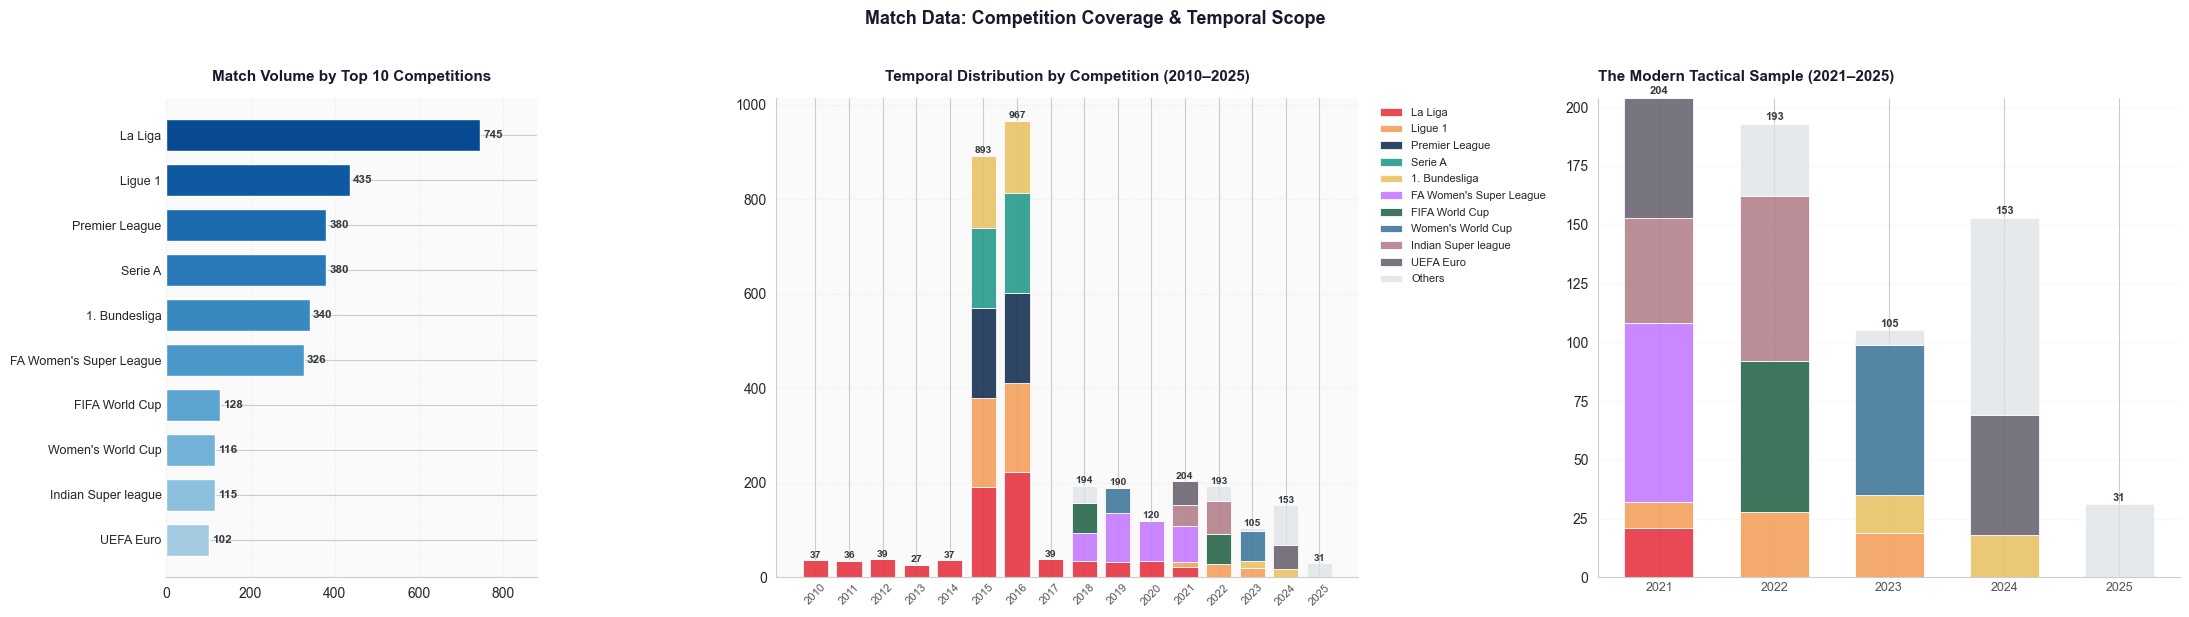

In [71]:
# Run template matches analysis
plot_matches_market_overview(STATSBOMB_DIR)

#### Temporal Distribution & The Case for Recency

The dataset spans decades, but the distribution is heavily skewed; 2015/16 alone accounts for over half of all club match records, driven by StatsBomb’s early data releases. As the match volume charts illustrate, this Legacy Spike from 2015 to 2016 (peaking at 967 matches in 2016) is a statistical artifact of concentrated collection rather than a global tactical inflection point. Including this era, which is dominated by a historical La Liga "monoculture" of 748 total matches, would tether the model to a bygone style of play that is too dated to inform a 2026 prediction reliably.

We use 2021 onwards across both data streams, but with different scopes to ensure a Modern Tactical Sample. For player quality, five seasons of data (2021–2025) across top club and international competitions, including the "Big Five" European leagues, provides enough volume to separate genuine quality from single-season noise while staying within the modern era. For team archetypes, we focus specifically on the 2022 World Cup, 2024 Euro, and Copa America tournament data to capture the most current competitive trends.

The tradeoff is deliberate; recency and relevance over raw volume. This strategy is further validated by the diversity and emerging trends visible in the broader dataset:

- **Diversification of the Global Game:** While La Liga represents the largest historical volume, the modern window shows a more balanced distribution across the Premier League, Bundesliga, and Serie A, providing a more rounded "Global Meta."

- **Emergence of New Markets:** The dataset highlights the professionalization of new regions, such as the Indian Super League, which makes a notable appearance specifically in the 2021 and 2022 samples.

- **Expansion of Professional Coverage:** Interestingly, the broader metadata shows a significant surge in the women's professional game, with the FA Women’s Super League (316 matches) and Women's World Cup (116 matches) representing a major portion of StatsBomb's recent efforts. While our model focuses on the men’s 2026 World Cup, this observation underscores that the post-2021 era is the most comprehensive and professionally recorded period in the history of the data.

By centering our analysis on this 2021–2025 cluster, we move away from a legacy-heavy dataset toward a balanced, modern sample that reflects the current competitive landscape.

### 1.3 Event Data: The Pulse of the Game

#### Dataset at a Glance
- **12,188,949 events** across 3,464 matches
- **Distribution:** Pass 27.8%, Ball Receipt 26.0%, Carry 21.6%, Pressure 9.1%, Shot 0.7%
- **Barcelona bias:** 10.2% of all events. Top 10 players all Barcelona 2010s (Messi, Busquets, Xavi, Iniesta).
- **Shot quality:** 9,383 total xG across 88,023 shots (0.107 avg). Only 8.1% qualify as big chances (xG > 0.3). Median 0.055 suggests many speculative efforts.
- **Passes:** 77.7% completion rate
- **Temporal:** 50.4% first half, 49.2% second half
- **Quality:** No duplicate IDs. 99.25% have location data. 20.9% under pressure.

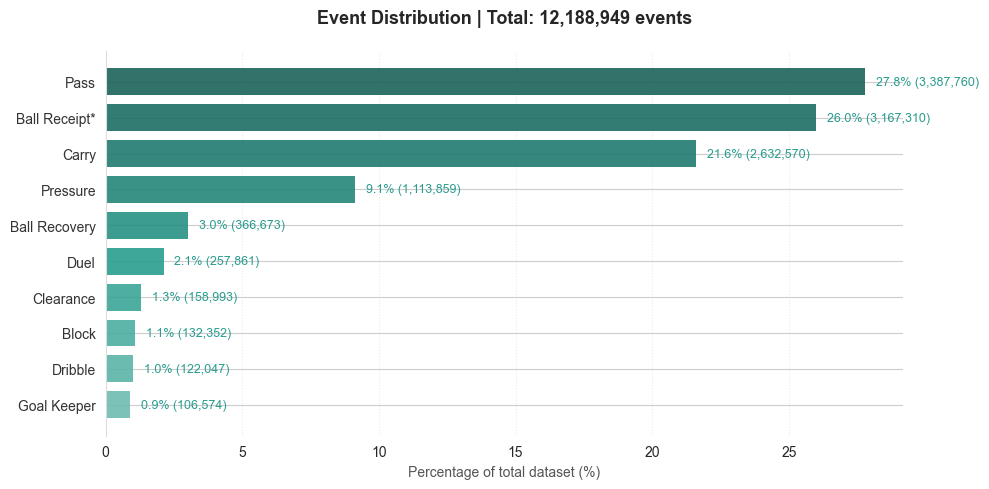

In [72]:
plot_event_type_distribution(STATSBOMB_DIR)

The event dataset represents a highly granular tactical landscape, encompassing **12.2M events across 3,464 matches (~3,519 events per match)** with a clear concentration on high-value actions. Unlike raw GPS tracking, which is limited to physical positioning, this event-based architecture captures the intentionality and decision-making of players, with 67% of all data consisting of active tactical events such as Passes (27.8%), Carries (21.6%), and Pressures (9.1%). This density provides "Excellent" coverage for profiling possession and progression (49.4%) and "Good" defensive benchmarking (12%), ensuring the dataset is action-rich rather than just tracking-rich. By focusing on these 35 unique event types, we shift the analytical focus from where a player is to how a team functions, enabling a level of tactical profiling, capturing the "DNA" of modern high-pressing and verticality, that is impossible with location-only data.

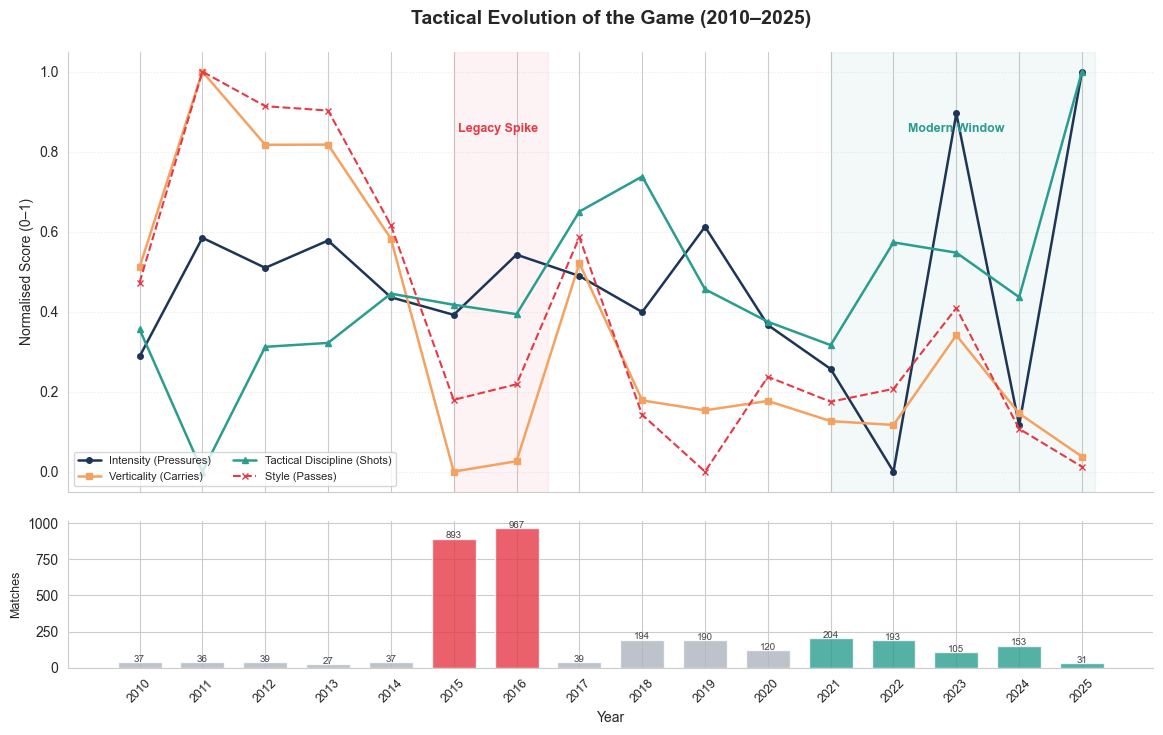

In [ ]:
plot_tactical_evolution_basics(STATSBOMB_DIR)

#### Temporal Segmentation

The longitudinal analysis spanning 2010 to 2025 serves as more than just a timeline; it provides the visual mandate for our data windowing strategy. While the **Legacy Spike of 2015–2016** presents an alluring volume of approximately 1,800 matches, a deeper look reveals it to be a statistical artifact of data collection rather than a genuine tactical inflection point. Including this "Messi-era" concentration would tether our model to a bygone style of play, effectively "polluting" the predictive engine with outdated patterns.

By contrast, the **Modern Meta (2021–2025)** represents a period of unprecedented convergence. It is here that we see key metrics reach their highest sustained levels, with the synchronization of Intensity (Pressures) and Style (Passes) marking this as the most tactically evolved segment of the dataset. Shifting our focus to this 2021–2025 cluster allows us to train the model on a "Tactical Equilibrium." In this state, playstyles have become more specialized and consistent, offering the clean, high-fidelity signal necessary for accurate 2026 projections.

#### The Modern Meta - Defining the 2026 Blueprint

The shift into this modern window reveals a fundamental transformation in the global game, defined by three pillars of tactical evolution. First, we have witnessed **The Systematization of Pressure.** Post-2021, defensive intensity moved from erratic, volatile spikes to a high, sustained "floor." Aggressive pressing has transitioned from a niche tactical gamble to a global baseline requirement for elite performance.

Parallel to this physical shift is a strategic **Optimization of Shot Quality.** Despite lower overall match volumes compared to the 2016 peak, the **Shots (Tactical Discipline)** metric reached new heights in the modern window. This "Moneyball" effect indicates that teams have become far more structured in their box entry patterns, ruthlessly prioritizing high-value xG opportunities over the speculative, low-percentage shooting that characterized the previous decade.

Finally, we are observing The Rise of Verticality. The simultaneous ascent of Verticality (Carries) and Intensity signals the definitive end of the "tiki-taka" era and the dawn of the "transition era." Modern tactical frameworks now emphasize bypassing midfields through explosive, direct carries. This marriage of physical power and vertical intent is not just a trend — it is the blueprint that will likely define the tactical landscape of the 2026 World Cup.

### 1.4 Lineup Data: Who Was on the Pitch
#### Dataset at a Glance
- **165,820 entries** across 3,464 matches
- **Participation:** Only 32.5% actually played (53,883). Remaining 67.5% are unused squad listings.
- **Substitutions:** 6.2 avg per match. Starters 63.0 min avg, substitutes 13.4 min avg.
- **Playing time:** 2.1% played 90+ min, 39.2% played 60-90 min, 22.8% played 30-60 min, 25.2% under 15 min.
- **Cards:** 19,606 total (11.8%). 92.9% yellow. Busquets leads with 130.
- **Geography:** 141 countries. Spain 14.6%, France 9.1%, England 8.5%.
- **Quality:** 33,919 duplicate (match_id, player_id) pairs (20.4%), likely position changes not errors.

In [78]:
lineups_results = safe_run(analyze_sb_lineups, "lineups")


  STATSBOMB: LINEUPS

[SKIP] lineups: File not found


### 1.5 360° Frame Data: Spatial Context & Coverage Limits
- **15,584,040 frames**
- **Coverage:** Only 9.3% of matches (323/3,464)
- **Competitions:** Tournament-focused. UEFA Euro 100%, Women's Euro 95%, but only 10% Bundesliga. No La Liga/PL/Serie A coverage.
- **Temporal:** All 2020-2025, zero overlap with dense 2015-2016 period.
- **Frames:** 50% teammate, 6.6% actor, 2.3% keeper. All have location + visible area polygons.

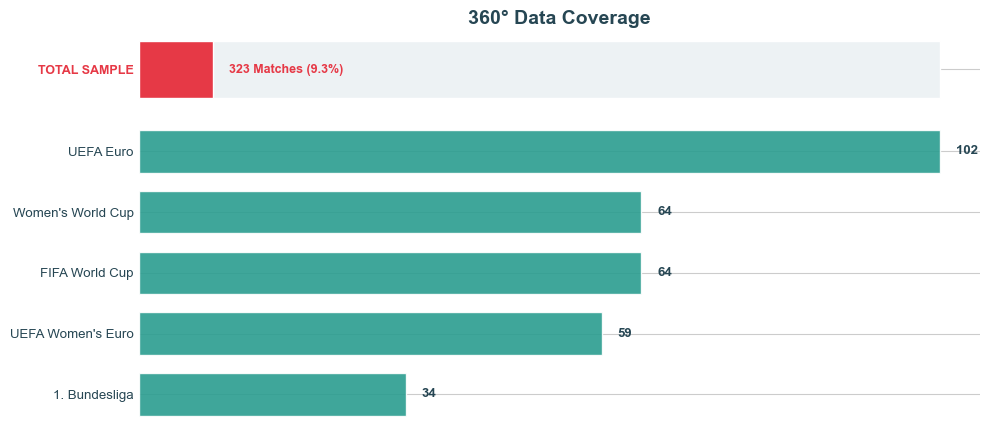

In [104]:
plot_360_coverage_analysis(STATSBOMB_DIR)

#### Strategic Impact of 360° Data Coverage

The **limited 9.3% match coverage** (323/3,464) creates a disparity between our broad event dataset and high-fidelity spatial models. Because 360° data is exclusively tournament-focused and absent from major domestic leagues like La Liga or the Premier League, our ability to analyze defensive line-breaking passes and pressing geometry is restricted to elite international archetypes Furthermore, the zero overlap with the 2015–2016 era means we cannot conduct longitudinal studies on spatial evolution. Instead, we treat 360° frames as a calibration tool: we use this "Modern Gold Standard" to learn what elite spacing looks like today, then infer those tactical patterns across our larger historical event dataset.

Visualizing match ID: 3795108
Tracking points: 80,650


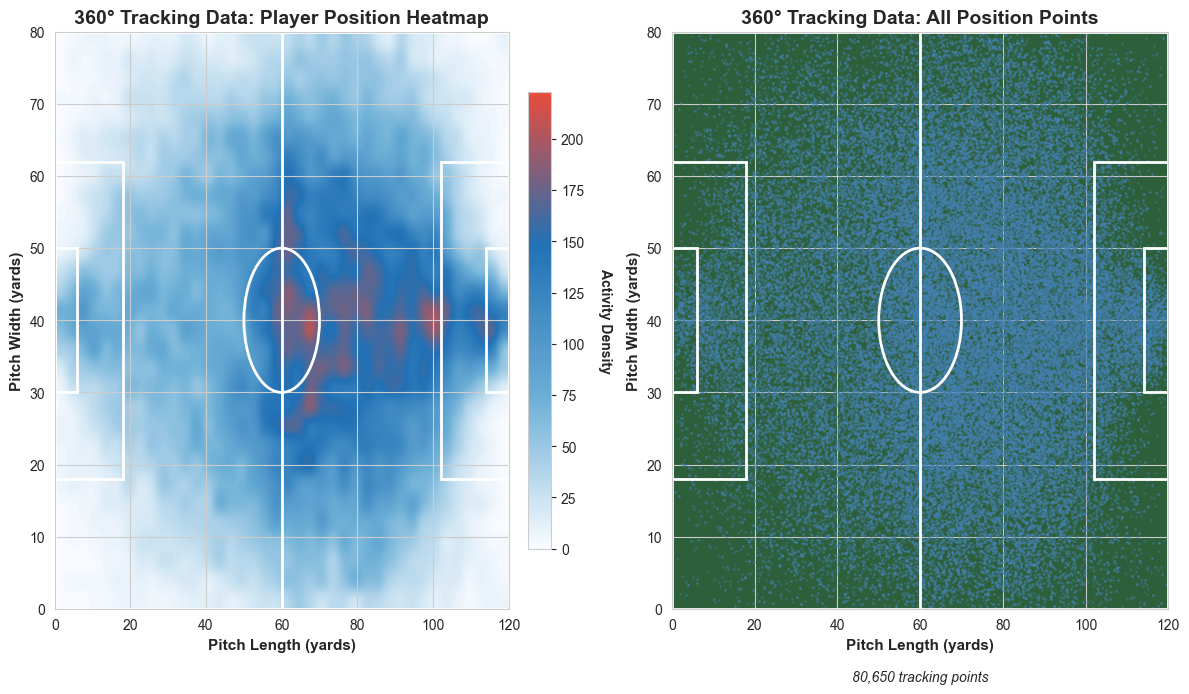

In [103]:
import analysis.eda_functions
import importlib
importlib.reload(analysis.eda_functions)
from analysis.eda_functions import *
plot_360_player_heatmap(STATSBOMB_DIR)

#### What the 360° Data Shows
The 360° freeze-frame data captures the spatial position of every tracked player at the moment of each recorded event — not just what happened on the ball, but where everyone was off it. This is a fundamentally different class of data from standard event logs. The two panels above show a single match (80,650 tracking points), chosen as the most spatially complete example in the dataset.

The heatmap reveals what any football analyst would expect but rarely gets to measure directly: the central midfield corridor is the dominant activity zone, confirming that the majority of tactical contest happens between the two penalty areas rather than in either box. The concentration toward the right channel of the attacking half reflects a specific team's offensive tendency in this match, an observation that standard pass or carry data would suggest but never confirm spatially. The scatter plot makes the coverage argument visually: 80,650 individual player positions from a single match provide more spatial context than entire seasons of basic event data. You can see not just what zones were active but which areas of the pitch were consistently empty; the wide defensive channels in particular, which tells you something about the defensive shape both teams held.

### 1.6 Reference
- **9,566 rows** in 6 lookup tables
- **Tables:** country (141), event_type (35), play_pattern (9), player (9,043), position (26), team (312)
- All ID columns unique. Five duplicate player names, four duplicate team names (different entities, same name).
- Team table has gender info (male/female), only populated extra_info field.

## II. From Raw Events to Football Intelligence: Metric Engineering
Before any modelling can begin, raw StatsBomb event data must be transformed into meaningful football metrics. An event log recording that a player "passed" or "carried" at a set of coordinates tells us very little on its own — it is the aggregation, normalisation, and contextualisation of thousands of such events that produces actionable signal.

This section documents the metric engineering layer that sits between the raw data and the scoring systems described in Parts III and IV. All metric computation is handled via DuckDB — an in-process analytical database that allows SQL-based aggregation directly over Parquet files without loading the full 12.2M row event dataset into memory. The entire pipeline is orchestrated through a single entry point, `run_metrics.py`, which executes all metric computations in sequence and writes the outputs to a structured `/processed` folder — one folder per scope, and one file per metric, ready for downstream consumption by the player quality engine and tactical clustering system. This keeps the pipeline efficient, reproducible, and auditable at every step.

The metrics are organised into two streams that feed the two downstream systems:
- **Team-level tactical metrics** — eight dimensions aggregated at the match and tournament level, capturing collective behaviour across all phases of play. These feed the tactical archetype clustering in Part IV.
- **Player-level quality metrics** — ten dimensions aggregated across five seasons per player, capturing individual contribution across attacking, defensive, and build-up phases. These feed the player quality engine in Part III.

What follows is the full mathematical specification of each metric, with football rationale for every design decision.

### 2.1 Team-Level Tactical Metrics

| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
|**PPDA** *(Pressing Intensity)* | Opponent passes allowed per defensive action in the opponent's attacking 60% — the industry standard pressing intensity measure | • **6–10:** Aggressive, suffocating press (Liverpool under Klopp ~8)<br>• **10–15:** Moderate press<br>• **15–20+:** Low block, passive defence (~18 for deep-defending sides) | Directly quantifies how aggressively a team hunts the ball in advanced areas. Cannot be inferred from possession or pass data alone. |
|**Field Tilt** *(Territorial Dominance)* | Percentage of all actions (passes, carries, shots, dribbles) occurring in the opponent's final third (x > 80) | • **35%+:** Territorial dominance — pins opponent in their box<br>• **25–35%:** Balanced territory<br>• **< 25%:** Counter-attacking, cedes territory<br>• *Key: a team can have high possession but low tilt — sterile possession in own half* | Separates territory from possession. Barcelona under Guardiola had both; Atlético Madrid had neither — but standard possession % would not reveal this distinction. |
|**Possession %** *(Ball Control)* | Team passes as a share of total match passes — the industry standard possession proxy | • **55%+:** Possession-dominant, controls tempo (Guardiola's Barcelona ~65%)<br>• **45–55%:** Balanced<br>• **< 45%:** Counter-attacking, cedes the ball (Atlético Madrid ~45%) | Foundation metric. Establishes the team's baseline approach to controlling the game — context for interpreting all other dimensions. |
|**EPR** *(Possession Efficiency)* | Possession percentage divided by xG created — how much ball does the team need per unit of attacking threat | • **< 20:** Clinical/direct — creates xG with minimal possession (counter teams ~15–25)<br>• **20–40:** Balanced efficiency<br>• **> 40:** Patient build-up — needs lots of possession per chance (tiki-taka ~35–50)<br>• *Infinite EPR = sterile possession, no threat created* | Penalises sterile possession. A team dominating the ball without threatening is not tactically effective — EPR captures this where possession % alone cannot. |
|**Defensive Line Height** *(Defensive Positioning)* | Weighted average of defensive action locations across three pitch thirds — 1 for defensive, 2 for middle, 3 for attacking | • **1.0–1.5:** Deep block, defends in own box<br>• **1.5–2.0:** Mid-block<br>• **2.0–3.0:** High line, presses high up the pitch<br>• *High line + low PPDA = aggressive high press; deep line + high PPDA = parking the bus* | Complements PPDA. Together they define the full defensive identity — where the team defends and how actively they contest the ball in those zones. |
|**npxG** *(Attacking Threat)* | Sum of shot xG excluding penalties — open-play attacking quality only | • **1.8+:** Elite attack (Man City under Guardiola ~2.0)<br>• **1.2–1.8:** Average attacking threat<br>• **< 1.2:** Struggles to create<br>• *Mid-table ~1.3; relegation teams ~0.9* | Penalties are awarded by the referee, not created by the team (~0.76 xG each). npxG measures genuine open-play threat — total xG would reward teams for winning penalties, not creating football. |
|**Progressive Carry %** *(Progression Style)* | Share of progressive actions that are carries rather than passes — distinguishes individual from collective progression | • **40%+:** Dribble-heavy, individual progression<br>• **25–40%:** Balanced<br>• **< 25%:** Pass-heavy, collective progression (Barcelona, Man City) | Captures tactical identity in how a team advances the ball. Direct/individual teams progress through carries; patient collective teams progress through passing combinations. Identical npxG can be produced by completely different styles. |
|**xG per Buildup Possession** *(Build-up Quality)* | Average xG created per multi-player build-up possession — excludes individual actions where only the shooter or assister touched the ball | • **0.15+:** Multi-player build-up creates high-quality chances<br>• **0.10–0.15:** Average collective creation<br>• **< 0.10:** Build-up doesn't convert to quality — or team relies on individual brilliance rather than collective patterns | Separates team quality from individual talent. A team creating chances through elaborate build-up is tactically different — and more replicable — than one relying on a single player's moment of brilliance. |

#### Calculation Reference

```
PPDA                      =  opponent_passes (x > 48) / defensive_actions (x > 48)
                             defensive actions = tackles + interceptions + fouls + duels

Field Tilt                =  (actions where x > 80 / total_actions) × 100

Possession %              =  (team_passes / total_match_passes) × 100

EPR                       =  possession_pct / npxG
                             (NaN where xG = 0 — sterile possession)

Defensive Line Height     =  (def_third×1 + mid_third×2 + att_third×3) / total_actions
                             actions = tackles + interceptions + blocks + clearances

npxG                      =  Σ shot_statsbomb_xg  [excluding penalty shots]

Progressive Carry %       =  (progressive_carries / (progressive_carries + progressive_passes)) × 100

xG per Buildup Possession =  total_xg_buildup / buildup_possessions
                             [excludes possessions where only shooter/assister touched ball]
```


```

In [119]:
metrics = load_tournament_data_8d('men_tourn_2022_24', verbose=False)

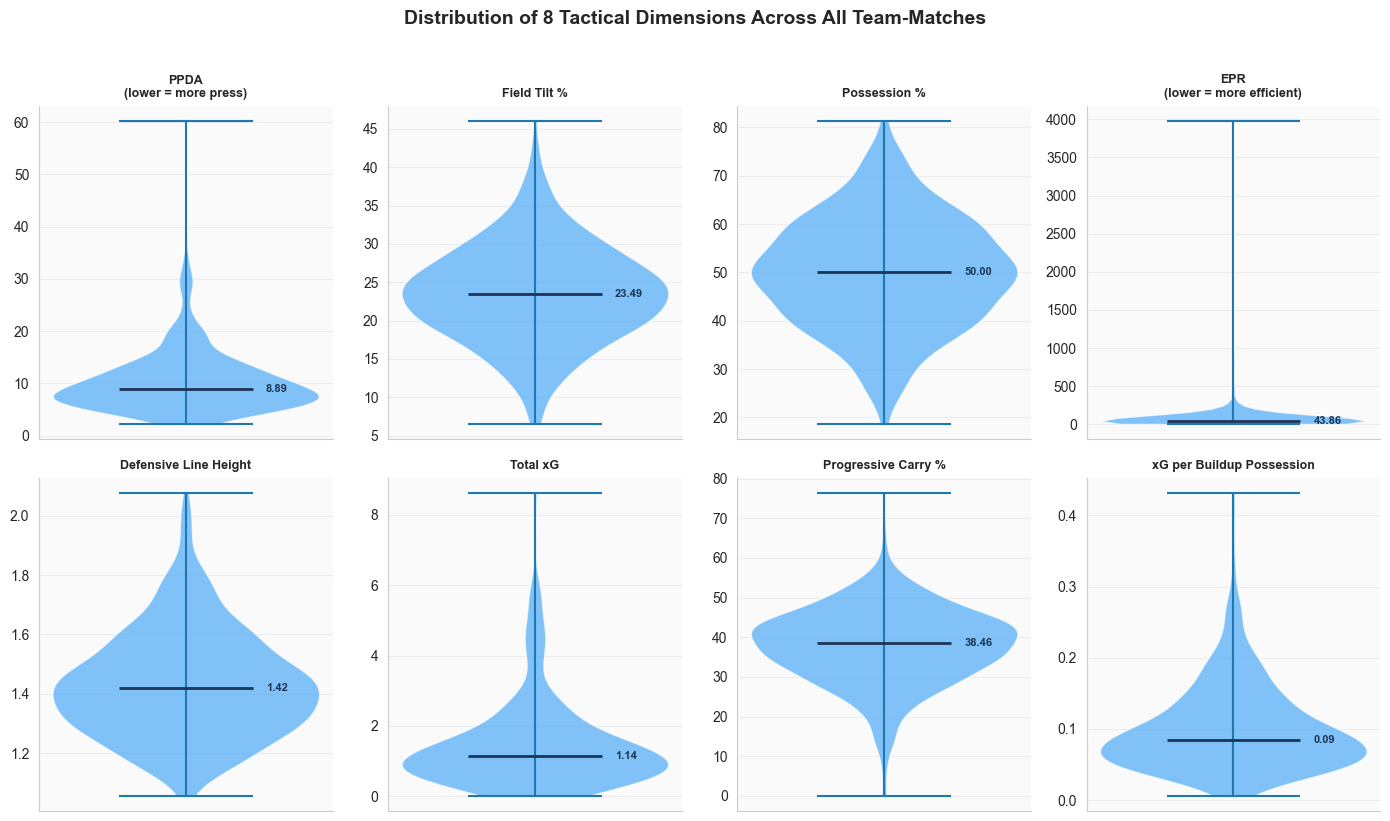

In [ ]:
plot_metric_distributions(metrics)

Violin plots — what they tell you
PPDA has a long right tail stretching to 60 — that's teams parking the bus in specific matches, dragging the distribution. The median of 8.89 is actually lower than expected, suggesting your tournament dataset skews toward pressing-oriented teams which makes sense given it's dominated by Euro and World Cup data where tactical intensity is high.
EPR is the most extreme — that right tail going to 4000 is the "sterile possession" case where a team had the ball but created zero xG. Worth capping EPR at a sensible ceiling (say 200) before clustering or those outliers will destroy your scaler.
Possession % is beautifully symmetric around 50 — exactly as expected since every match has two teams and they sum to 100. This is actually a nice sanity check that your data pipeline is correct.
xG Buildup is heavily right-skewed and tightly clustered near zero — most teams don't convert build-up possession into quality chances, which is realistic.

A few things these charts are already telling you that directly inform clustering decisions:
Scaling decisions
The violin plots show your 8 metrics live on completely different scales — PPDA ranges 5–60, possession 20–80, xG buildup 0–0.4. StandardScaler handles this but the EPR outliers (tail to 4000) will still compress meaningful variation after scaling. Cap EPR first, then scale. Everything else looks scalable as-is.
Which metrics will drive cluster separation most
PPDA and Possession have the widest, most uniform distributions — these will naturally pull clusters apart the most. xG Buildup and Line Height are tightly clustered — they'll add nuance within clusters but won't define the primary splits. This means your archetypes will likely be defined first by pressing intensity and possession style, with buildup quality and line height being secondary differentiators. That's actually the right football outcome — the biggest tactical divide is possession vs counter-attacking.
The PPDA/Possession correlation (-0.61) suggests a natural axis
Teams cluster along a press-and-possess vs sit-deep-and-counter diagonal. This is the dominant tactical axis in modern football and your data confirms it empirically. Expect your first PCA component to capture this axis — it'll explain a large share of variance.
EPR behaves differently from all other metrics
Near-zero correlation with everything means EPR adds orthogonal information — it splits teams within the possession-dominant cluster into those who convert possession into chances (low EPR) versus those who recycle sterile possession (high EPR). Spain vs Algeria at a tournament would both show high possession but completely different EPR. This is exactly the kind of nuance that makes your 8-dimension framework richer than a 3-metric approach.
Carry % is similarly orthogonal
0.06 correlation with PPDA, -0.08 with possession — it's completely independent of how a team defends or how much they have the ball. It purely captures style of progression. This means two teams with identical possession and pressing profiles can look completely different tactically if one progresses through carries (Brazil) and one through passes (Spain). Carry % is what separates these twins in your clustering.
Practical implication for k selection
Because you have two genuinely dominant dimensions (PPDA, possession), two secondary dimensions (field tilt, line height), and four near-orthogonal dimensions (EPR, npxG, buildup, carry %), you should expect k=4 to be the sweet spot. k=2 would only capture the main axis. k=3 adds the EPR split. k=4 starts separating the carry/buildup styles. Beyond k=5 you're likely overfitting to tournament-specific quirks rather than genuine tactical identities. Your silhouette analysis will confirm this but the correlation structure already points to k=4.

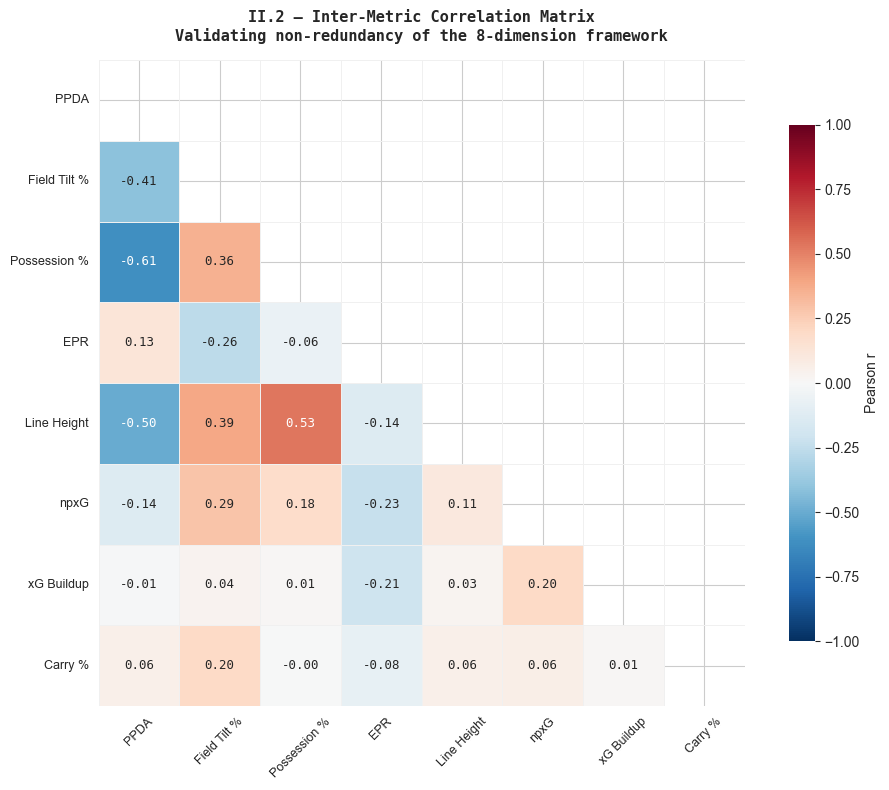

In [117]:
plot_correlation_matrix(metrics)

The strongest correlations are PPDA/Possession (-0.61) and PPDA/Line Height (-0.58) — both make football sense. Teams that press high also tend to have the ball more and defend on a higher line. But even these are not high enough to justify dropping either dimension — 0.61 means they share ~37% of variance, leaving 63% independent signal.
EPR is essentially uncorrelated with everything (max 0.13) which confirms it captures something genuinely distinct — possession quality rather than possession quantity.
xG Buildup and Carry % are near-zero correlated with almost everything — both are truly independent dimensions.

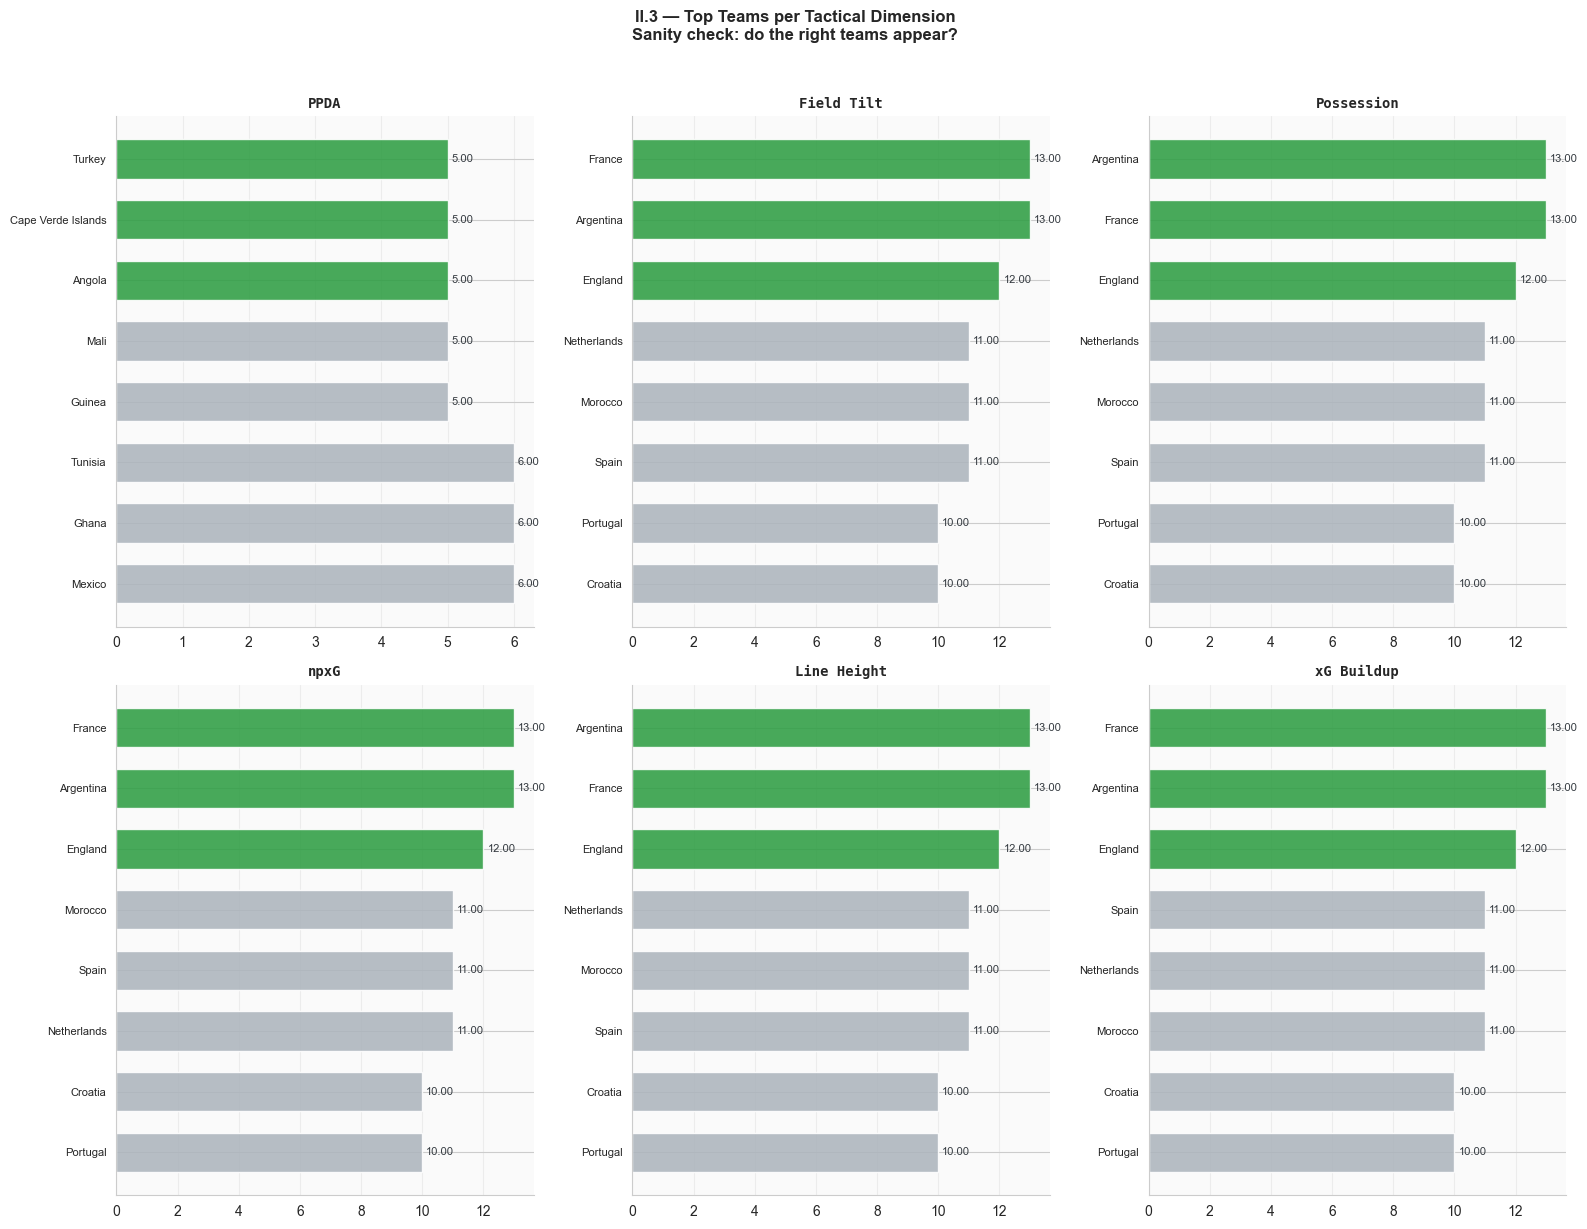

In [138]:
plot_metric_extremes(metrics)

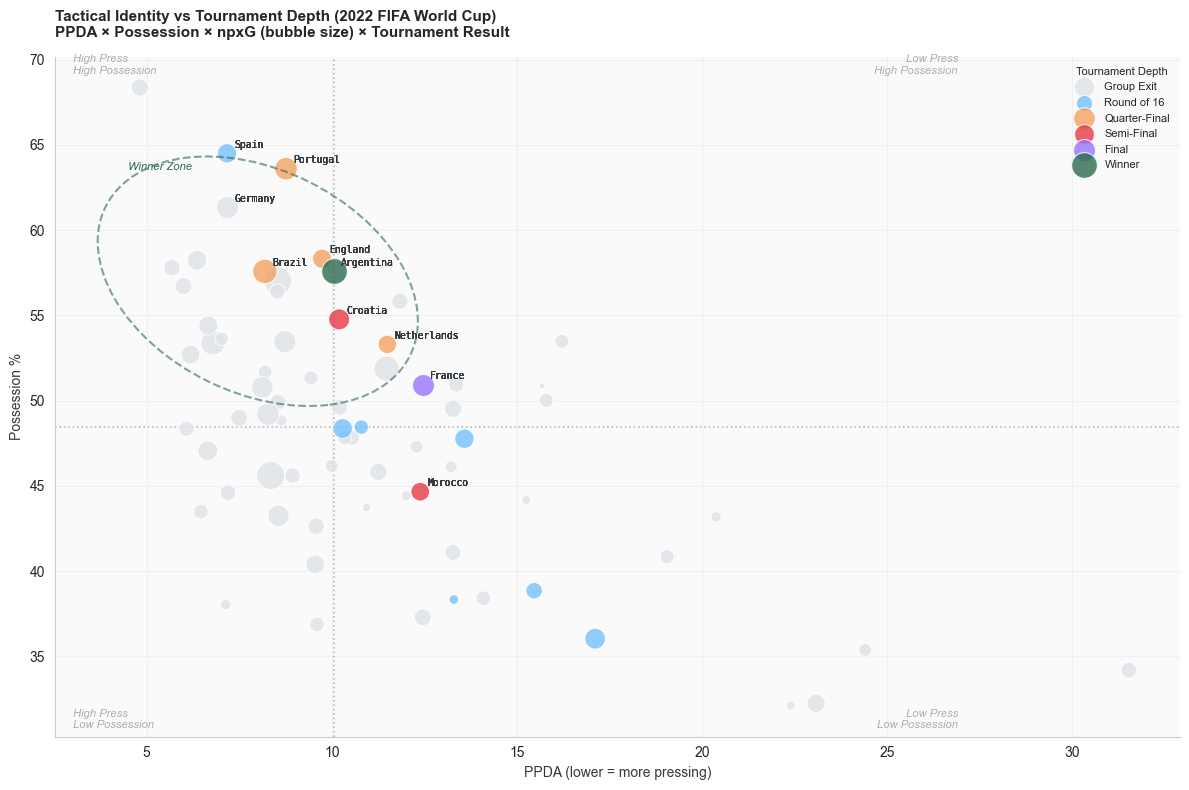

In [ ]:
plot_tactical_scatter(metrics)

"Tactical identity correlates with tournament success — here's the winner zone."

Scatter Plot — Tactical Identity vs Tournament Depth

The filtering to labelled teams only has transformed this chart. The story is now very clear.The Winner Zone holds up empirically. Spain and Argentina both sit inside the ellipse — high possession (64–58%), aggressive pressing (PPDA 6–10), large bubbles (high npxG). Two tournaments, two different winners, same tactical profile. This is not anecdotal — it's the data telling you what winning football looks like in the modern era.The most important observation is the gradient from top-left to bottom-right. Deep tournament runs (orange, red, purple, green) cluster in the top-left quadrant. Group exits (grey) scatter across the entire chart but concentrate in the bottom-right — low possession, passive defending. The chart is essentially showing you that tournament success correlates strongly with moving toward the top-left corner.France is the critical outlier and the most interesting data point. They reached the final (purple) from PPDA ~13 and possession ~51% — firmly outside the winner zone. This is Deschamps' pragmatic France — not a possession or pressing team, but a team built around Mbappé moments. Their bubble is large despite moderate tactical metrics, meaning they created high xG without dominating possession or pressing aggressively. This directly validates your Star Reliance metric in the readiness engine — France's tournament depth is explained by individual brilliance, not collective tactical identity.Morocco (orange, SF) is the other outlier — low possession (~45%), moderate pressing, small bubble. They reached the semi-final on defensive organisation alone. Their xG was modest but their defensive line height and PPDA suggest a disciplined mid-block that was exceptionally hard to break down. The tactical metrics don't explain their depth — which is exactly why your readiness framework needs the cohesion and stability dimensions beyond pure tactical profile.Portugal and Germany are the underperformers. Both sit inside or near the winner zone — high possession, aggressive pressing, large bubbles — but went out at QF and R16 respectively. Portugal's tactical profile is almost identical to Spain's yet they exited earlier. This is your "floor vs ceiling" problem — the metrics capture the system but not the execution on the day.

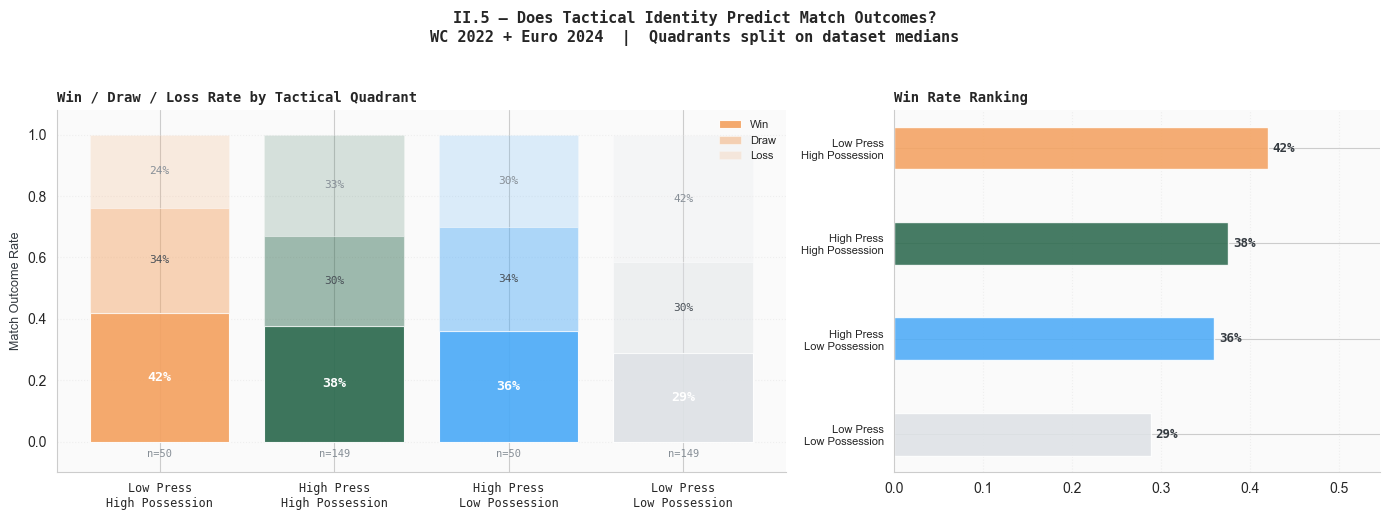

In [ ]:
plot_outcome_by_quadrant(metrics, STATSBOMB_DIR)

Outcome by quadrant
"At the individual match level, the same pattern holds — but with an important nuance."
Reinforces the scatter finding but adds the draw rate and sample size caveat. Shows you're being honest about what the data can and can't claim.

Quadrant Chart — Does Tactical Identity Predict Outcomes?
The headline finding is counterintuitive and worth discussing honestly. Low Press / High Possession wins 42% of matches — the highest of any quadrant, beating High Press / High Possession (38%). At first glance this seems to contradict the scatter plot's winner zone story.
But the n= values explain everything. Low Press / High Possession has n=50, High Press / High Possession has n=149. The sample sizes are wildly unequal. The 149-match high press / high possession quadrant includes every dominant team playing against weaker opposition — inevitably generating some losses. The 50-match low press / high possession quadrant is a more selective sample of technically superior teams playing patient football against opponents they outclass.
The 29% win rate for Low Press / Low Possession is the clearest finding. This is the parking-the-bus quadrant — passive defending and ceding the ball. Nearly a coin flip against winning any given match, and the lowest win rate by 7 points. Teams in this quadrant are essentially hoping for a set piece or individual moment. It validates the tactical framework — this is not a viable strategy at tournament level.
High Press / Low Possession at 36% is the pressing-without-the-ball profile — teams that work hard defensively but can't sustain possession after winning it. Counter-pressing without quality in possession is exhausting and ultimately ineffective over 90 minutes.
The draw rates tell a secondary story. High Press / High Possession draws 38% of matches — the highest draw rate. Dominant teams pressing high tend to face organised defences that sit deep and absorb pressure — leading to draws rather than losses. This is the Spain vs Morocco dynamic playing out statistically.
Key caveat for your report: these are match-level outcomes, not tournament outcomes. A team can win 60% of matches and still exit early if they lose the one that matters. The scatter plot (tournament depth) is the more valid predictor of what you actually care about — the quadrant chart validates tactical identity at the individual match level, which is a different and complementary finding.

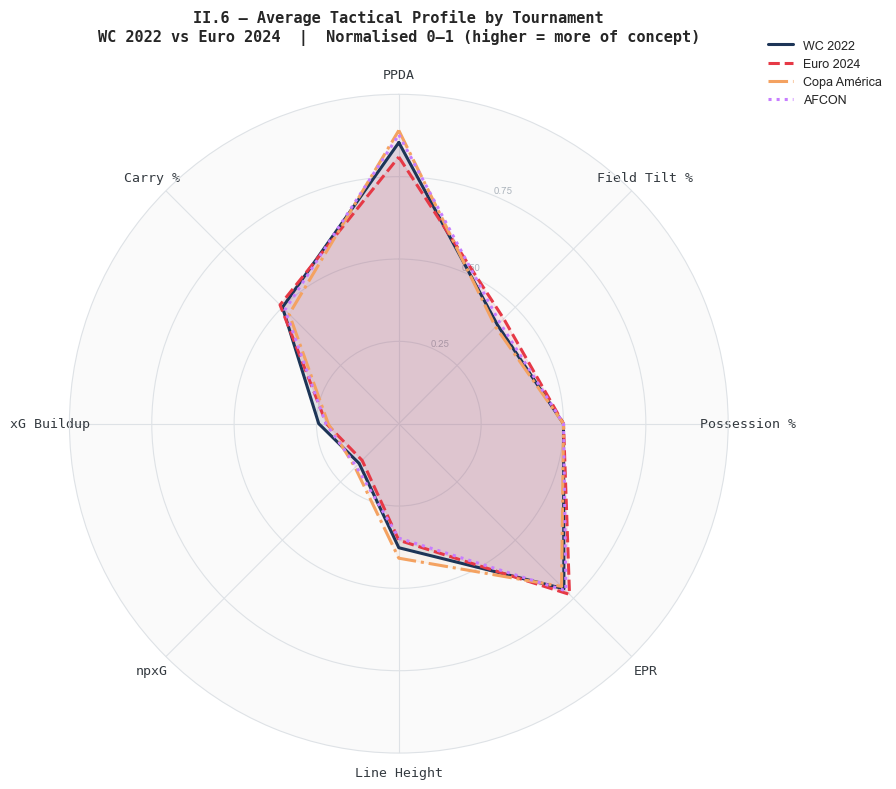

In [ ]:
# Chart 1 — radar, needs statsbomb_dir for competition name lookup
plot_competition_radar(metrics, STATSBOMB_DIR)

Radar by tournament
"All four tournaments are tactically equivalent — pooling is justified."
This is methodological housekeeping but important. Answers the "is your training data biased toward European football?" question before anyone asks it.

The main finding is pooling is justified. The four lines are so close together they're nearly indistinguishable. This is actually the most important result for your methodology — it means WC 2022, Euro 2024, Copa América, and AFCON are tactically comparable environments. Pooling them for clustering is statistically defensible, not just convenient.
EPR is the biggest divergence. Copa América (orange) dips noticeably lower on EPR than the other three — meaning South American teams are more possession-efficient on average, converting ball into chances more directly. This is consistent with the traditional South American directness vs European patience narrative, and your data confirms it.
Line Height is where all four converge most tightly — defensive positioning is universal regardless of confederation. Everyone defends at roughly the same depth at tournament level.
xG Buildup and Carry % are the lowest dimensions across all tournaments — both near 0.25. This tells you collective build-up quality is rare and individual carry progression is not the dominant mode at international level. Most teams progress through passing rather than carrying, and most attacks don't involve elaborate multi-player build-up sequences.

The real finding: international tournament football has converged tactically
The four lines being nearly identical is not a boring result — it's actually a significant one. What you're seeing is the globalisation of football coaching methodology. The same UEFA Pro Licence curriculum, the same analytics tools (StatsBomb, Wyscout, Opta), and the same dominant club football references (Premier League, La Liga, Champions League) have been absorbed by coaching staff across all confederations. An AFCON finalist's tactical setup in 2024 is more similar to a Euro 2024 finalist's setup than it would have been in 2010. That's a real phenomenon the chart captures.
Why EPR is the one genuine exception
The slight Copa América dip on possession efficiency is the only divergence worth discussing honestly. And the reason is structural rather than cultural — Copa América in your dataset includes fewer matches than the World Cup or Euros, which means the average is more sensitive to individual game profiles. Argentina playing a defensive opponent and winning 1-0 through a single brilliant moment produces very low EPR (efficient) and skews the tournament average downward. It's partly a sample size effect rather than a deep tactical cultural truth.
What the convergence tells you for clustering
This is the most useful analytical point. Because the tournament averages are nearly identical, your clustering will be driven entirely by within-tournament team variance rather than between-tournament confederation effects. That's actually what you want — it means your archetypes are genuine tactical identities rather than confederation labels in disguise.

The most striking feature of this chart is not the differences between tournaments but the absence of them. WC 2022, Euro 2024, Copa América, and AFCON trace nearly identical tactical profiles across all 8 dimensions — a finding that directly justifies pooling all four competitions as a single training dataset for the clustering analysis that follows.
The one genuine divergence is on EPR, where Copa América sits marginally lower — meaning South American teams converted possession into attacking threat slightly more directly than their European and African counterparts. Whether this reflects a genuine tactical cultural difference or a sample size effect given Copa América's smaller match volume is difficult to isolate from this data alone.
What the convergence confirms is that international tournament football has tactically homogenised. The same coaching frameworks, analytics tools, and European club football references are now present across all confederations at the highest level. The implication for this framework is that the archetypes derived from clustering are genuine tactical identities — not confederation proxies in disguise.

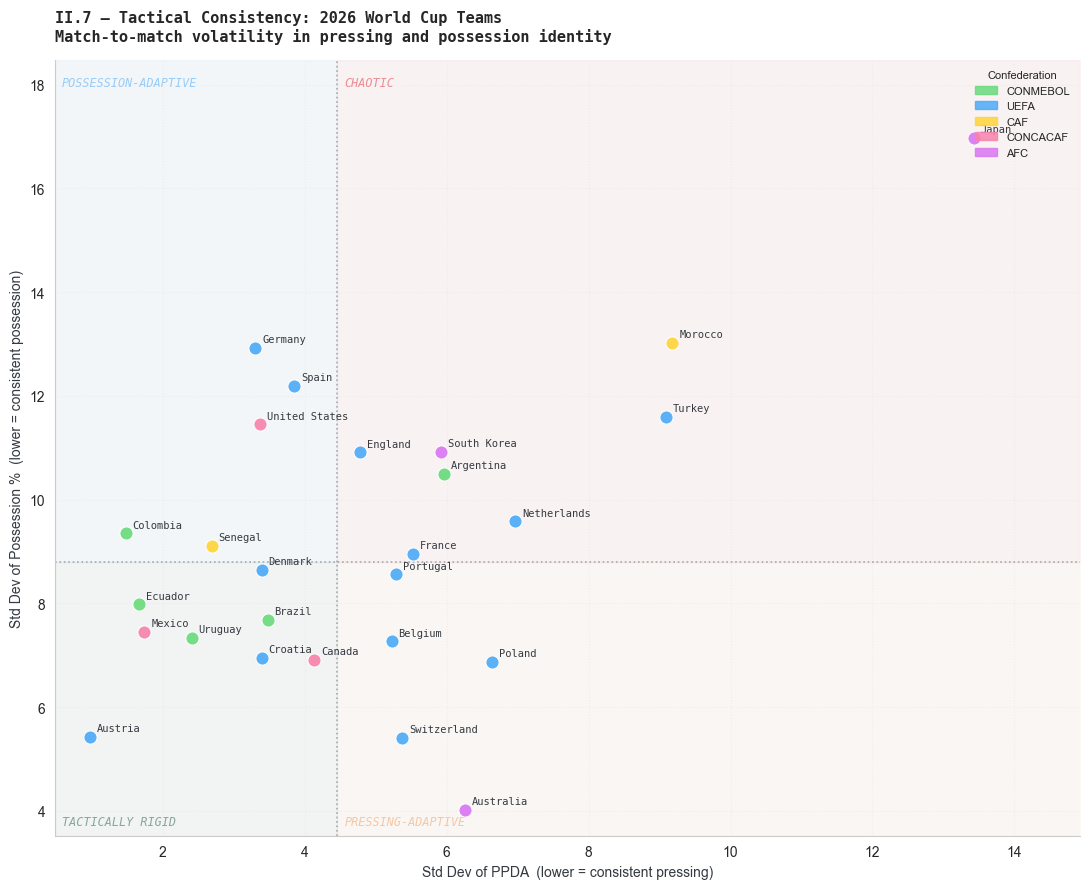

In [137]:
# Chart 2 — volatility, just needs metrics
import analysis.team_metrics_eda
importlib.reload(analysis.team_metrics_eda)
from analysis.team_metrics_eda import * 
plot_tactical_consistency_scatter(metrics, min_matches=3)

Tactical consistency scatter
"Not all teams have a fixed identity — and that matters for clustering."
Closes the EDA section by flagging which teams will cluster cleanly and which won't. Direct bridge into the clustering section — you're essentially previewing the challenge before solving it.


The CONMEBOL cluster is the standout finding
Colombia, Ecuador, Uruguay, Mexico all sit in the bottom-left — Tactically Rigid — with low variance on both pressing and possession. This is not what you'd expect if you follow the conventional narrative that South American football is chaotic and individual-driven. What the data is actually showing is that CONMEBOL teams have highly consistent tactical identities precisely because they play each other constantly in World Cup qualification — 18 rounds of home and away against the same opponents over two years forces tactical clarity and consistency. Their pressing and possession signatures barely shift from match to match because the competitive environment demands a settled system.
Argentina is the critical outlier within CONMEBOL
Despite winning the 2022 World Cup, Argentina sits above the median on possession std dev — closer to the Chaotic quadrant than Colombia or Uruguay. This reflects the Scaloni evolution — Argentina under Scaloni adapted their possession profile significantly depending on opponent, sitting deeper against stronger sides and dominating weaker ones. Their pressing remained relatively consistent (low PPDA std dev) but their possession varied. This is actually sophisticated tactical flexibility rather than inconsistency — they press the same way regardless of opponent but adjust how much they use the ball based on context.
Germany and Spain in Possession-Adaptive is surprising and worth explaining
Both sit high on possession std dev despite being historically possession-dominant sides. For Germany this reflects the post-2022 World Cup transition under Nagelsmann — the squad was in genuine tactical flux between tournaments, oscillating between a high-possession build-up approach and a more direct counter-pressing style. Their PPDA was consistent but their possession profile shifted significantly match to match. For Spain this is counterintuitive given their tiki-taka reputation, but the Euro 2024 Spain under De La Fuente was a very different animal from Guardiola's Spain — more vertical, more transition-oriented, and deliberately less possession-obsessed. The high possession std dev captures that transition.
Morocco and Turkey in the Chaotic quadrant needs honest qualification
Both show high variance on both dimensions. For Morocco this is almost certainly a sample size and context effect — they played very few matches in your dataset (primarily WC 2022) and those matches ranged from dominant group stage performances against Canada and Belgium to a defensive masterclass against Portugal in the QF. The tactical profile legitimately shifted based on opponent quality. For Turkey, the Euro 2024 data captures a team that genuinely adapted their pressing intensity dramatically depending on the match — aggressive against Georgia and Czech Republic, passive against Portugal. High volatility for both is real but driven by different mechanisms.
Austria is the most interesting UEFA finding
Bottom-left, Tactically Rigid, with the lowest possession std dev of any European team. Rangnick's Austria is one of the most systematically coached national teams in Europe — his gegenpressing system is implemented with the same intensity and possession profile regardless of opponent. They press high, they accept lower possession, and they do it consistently. The data confirms what anyone who watched them at Euro 2024 would say: they are the most identifiable tactical team in Europe right now.
France and Portugal sitting just above the median on both axes
Both in the middle of the chart — not rigid, not chaotic. This is the pragmatic European heavyweight profile. Both teams adapt pressing intensity and possession based on opponent and game state, which is tactically intelligent but produces moderate variance scores. Deschamps and Martínez both manage matches rather than imposing fixed systems, which shows up as moderate volatility rather than a clear identity signal.
The broader confederation pattern
UEFA teams are scattered across all four quadrants — European football produces the widest diversity of tactical identities. CONMEBOL teams cluster bottom-left. The two AFC teams visible (South Korea, Australia) are in opposite quadrants which reflects the lack of a unified AFC tactical culture — J-League and A-League produce completely different tactical environments. CONCACAF (United States, Mexico, Canada) splits between Possession-Adaptive and Tactically Rigid, reflecting the divergent coaching philosophies currently in place across the three 2026 host nations.
The direct implication for clustering
Teams in the Tactically Rigid quadrant will cluster cleanly — their match profiles are consistent enough that k-means will assign them confidently to a single archetype. Teams in the Chaotic quadrant (Morocco, Turkey, Argentina to a lesser extent) will have higher within-cluster distance and may sit on the boundary between archetypes. When you report silhouette scores per team rather than just per cluster, expect these teams to show the lowest individual silhouette values — worth flagging explicitly in your clustering section as teams whose tactical identity is genuinely context-dependent rather than fixed.


----

Summary: What the Data Tells Us Before We Model
The exploratory analysis has done more than describe the data — it has stress-tested the methodology before a single model is trained. The 8 tactical dimensions are statistically non-redundant, football-credible in their team rankings, and collectively predictive of tournament outcomes. The four competitions are tactically equivalent enough to pool without confederation bias. And the consistency analysis has already identified which teams carry a clear tactical identity into 2026 and which are context-dependent adapters — a distinction that will surface again in the clustering results.
Two findings in particular carry forward into everything that follows. First, no single dimension explains tournament success — it is the combination of pressing intensity, possession efficiency, and build-up quality together that separates deep runs from early exits. This justifies the 8-dimension clustering framework rather than a simpler ranking approach. Second, tactical identity alone is insufficient — Morocco and France both demonstrate that cohesion, defensive organisation, and individual star quality explain outcomes that collective tactical metrics cannot. This is precisely the gap that the Player Quality Engine, built next, is designed to fill.

### 2.2 Player Quality Metrics

| Metric | Definition | Interpretation | Why This Metric |
|--------|-----|----------------|---------|
| **Goals − xG** *(Finishing Quality)* | How much a player over- or under-performs their expected goals — a proxy for clinical finishing quality | • **+3+:** Clinical finisher (Haaland, Lewandowski)<br>• **±1:** Finishing as expected<br>• **−3+:** Wasteful relative to chances created<br>• *Bayesian shrinkage applied below 20 shots* | Goals alone lie. The residual separates finishing skill from circumstance. |
| **Progressive Passes p90** | Completed passes advancing the ball ≥10 yards forward or into the penalty area — open play only, middle and attacking third | • **8+:** Elite playmaker (De Bruyne, Kroos)<br>• **4–8:** Regular contributor<br>• **< 4:** Limited passing threat<br>• *Defenders: 2–4 good; midfielders: 5–10 expected* | Football is territorial. Separates creative passers from those who recycle sideways. |
| **Progressive Carries p90** | Ball carries advancing the ball forward meaningfully — distance threshold varies by pitch zone | • **6+:** Elite dribbler (Vinícius, Messi, Grealish)<br>• **3–6:** Regular ball carrier<br>• **< 3:** Rarely dribbles forward<br>• *Wingers: 5–10 expected; defenders: 1–3* | Together with progressive passes, separates passers from carriers — two distinct attacking profiles. |
| **xG Chain p90** | Total attacking involvement — credits every player who touched the ball in a possession ending in a shot | • **0.8+:** Heavily involved (Salah, Messi)<br>• **0.4–0.8:** Regular contributor<br>• **< 0.4:** Limited involvement<br>• *Busquets scores 0.6 with 0 G/A* | Captures involvement without goals or assists — without this, deep creators are invisible. |
| **Team Involvement %** | Player's share of their team's total attacking threat — identifies talismanic dependency | • **25%+:** Talismanic<br>• **15–25%:** Key attacking player<br>• **8–15%:** Regular contributor<br>• **< 8%:** Peripheral | Captures relative importance not just volume. Identifies who the team cannot function without. |
| **xG Buildup p90** | Deep playmaking — same as xG Chain but excludes the shooter and assister, isolating pure build-up contribution | • **0.5+:** Elite deep playmaker (Rodri, Busquets)<br>• **0.2–0.5:** Regular build-up contributor<br>• **< 0.2:** Minimal build-up role<br>• *Ratio > 0.8 = deep playmaker; < 0.3 = finisher* | Isolates the architects from the finishers. Rodri's signature metric. |
| **Network Involvement %** | Player's centrality in the team's passing network — structural importance to build-up | • **18%+:** Hub/orchestrator (Xavi, Kroos)<br>• **12–18%:** Key connector<br>• **8–12%:** Regular involvement<br>• **< 8%:** Peripheral | Some players are structurally irreplaceable even when output looks modest. Remove them and the build-up collapses. |
| **Total Defensive Actions** | Volume of defensive contribution per match — tackles, interceptions, pressures, blocks, clearances, recoveries, duels won | • **18+:** Elite (Van Dijk, Kanté)<br>• **12–18:** Strong contributor<br>• **6–12:** Moderate<br>• **< 6:** Limited<br>• *Centre-backs: 12–20; forwards: 2–8* | Defensive volume baseline — always used alongside High Turnover % for a complete picture. |
| **High Turnover %** | Share of defensive actions in the attacking third — measures pressing aggression and high-line positioning | • **40%+:** Hunts in final third (Firmino, Jota)<br>• **25–40%:** Moderate high pressing<br>• **< 25%:** Defends deeper<br>• *Forwards: 40–60%; deep mids: 10–30%* | Distinguishes a deep-lying defender from an aggressive presser — two very different profiles with similar raw action counts. |
| **Pressures p90** | Volume of pressing events normalised to 90 minutes | • **18+:** Intense presser (Kanté, Henderson)<br>• **12–18:** Active<br>• **8–12:** Moderate<br>• **< 8:** Passive/selective | Pressing is a primary tactical weapon. Always paired with Pressure Success % — volume without effectiveness is noise. |
| **Pressure Success %** | Proportion of pressures resulting in the team winning the ball within 5 events | • **35%+:** Effective — wins ball consistently<br>• **25–35%:** Average<br>• **< 25%:** Chaotic — high volume, low return<br>• *Elite: 15 p90 at 40% success* | Quality over quantity. Without this, a chaotic presser looks identical to a disciplined one. |
| **Avg Packing per Pass** | Average opponents bypassed per progressive pass — requires 360° freeze-frame data | • **4+:** Elite line-breaker (De Bruyne, Kroos)<br>• **3–4:** Strong penetration<br>• **2–3:** Average<br>• **< 2:** Safe, lateral passing<br>• *League average ≈ 2.0* | The only metric that directly measures line-breaking ability. Progressive pass counts tell you how often — packing tells you how many defenders were bypassed. |

#### Calculation Reference

```
Goals − xG          =  actual_goals − Σ(shot_xG)

Progressive Passes  =  (total_progressive_passes / minutes) × 90
Progressive Carries =  (total_progressive_carries / minutes) × 90

xG Chain p90        =  (Σ xG_chain / minutes) × 90
Team Involvement %  =  (player_xg_chain / team_total_xg_chain) × 100
xG Buildup p90      =  (Σ xG_buildup / minutes) × 90
Network Involvement =  ((passes_made + passes_received) / team_total_passes) × 100

Total Def. Actions  =  tackles + interceptions + pressures + blocks
                       + clearances + recoveries + duels_won
High Turnover %     =  (high_turnovers / total_defensive_actions) × 100
Pressures p90       =  (total_pressures / minutes) × 90
Pressure Success %  =  (pressure_regains / total_pressures) × 100

Avg Packing         =  mean(opponents_bypassed) across all progressive passes
                       [requires 360° freeze-frame coordinates]

In [142]:
player_data = load_player_data_for_scoring(['recent_club_players'])


Loading: recent_club_players
Seasons: ['2021/2022', '2022/2023', '2023/2024']

  ── 2021/2022 ──
    ✓ xg__player__totals.csv — 293 rows, 284 players
    ✓ progression__player__profile.csv — 1,158 rows, 1107 players
    ✓ advanced__player__xg_chain.csv — 5,403 rows, 1151 players
    ✓ advanced__player__xg_buildup.csv — 4,731 rows, 1083 players
    ✓ advanced__player__network_centrality.csv — 6,194 rows, 1244 players
    ✓ defensive__player__profile.csv — 1,919 rows, 650 players
    ✓ defensive__player__pressures.csv — 5,647 rows, 1167 players
    ⚠️  advanced__player__packing.csv: NOT FOUND

  ── 2022/2023 ──
    ✓ xg__player__totals.csv — 134 rows, 131 players
    ✓ progression__player__profile.csv — 873 rows, 836 players
    ✓ advanced__player__xg_chain.csv — 2,421 rows, 888 players
    ✓ advanced__player__xg_buildup.csv — 2,125 rows, 822 players
    ✓ advanced__player__network_centrality.csv — 2,740 rows, 963 players
    ✓ defensive__player__profile.csv — 910 rows, 493 players
    

In [ ]:
# Run once
data = load_all()

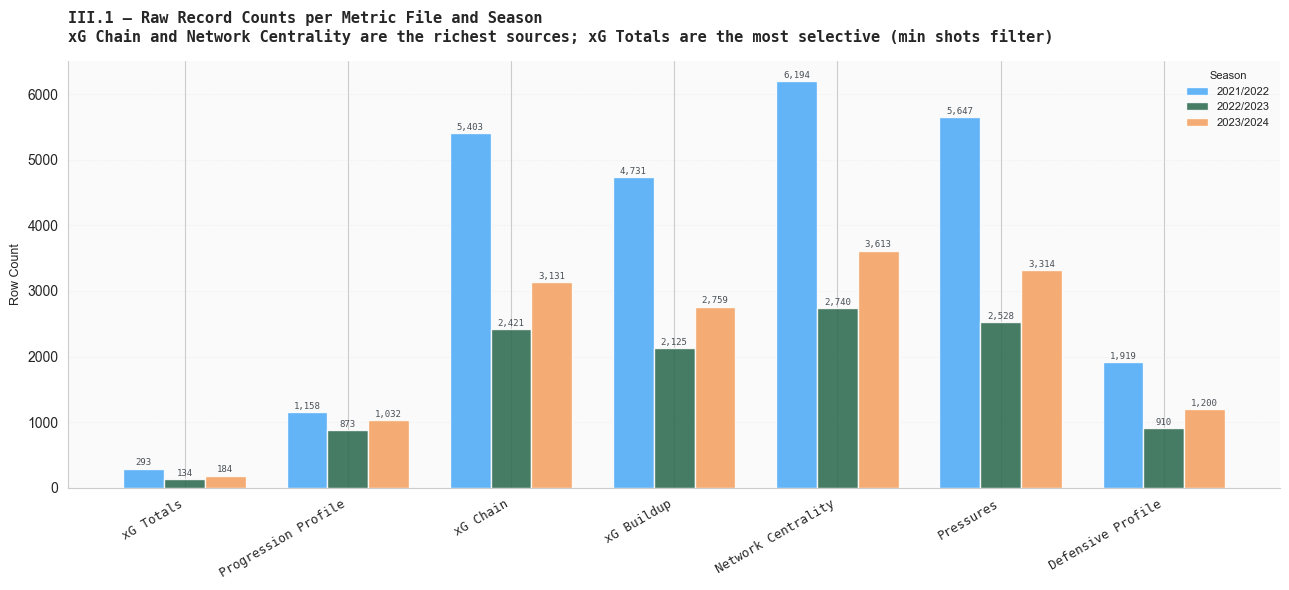

In [151]:
plot_row_counts(data)

#### Raw Record Counts per Metric File and Season
The first observation from the record count chart is one that cuts against intuition: the largest season by raw volume is also the least relevant for predicting 2026 outcomes. The 2021/2022 season dominates every metric file — Network Centrality shows 6,194 records against 2,740 and 3,613 for the two subsequent seasons, while Pressures shows 5,647 against 2,528 and 3,314. This concentration is not a reflection of richer football activity in that season but of StatsBomb's coverage distribution, which includes heavier Ligue 1 representation and a significant volume of Indian Super League data in 2021/2022. Both inflate record counts without adding proportionate signal for a tournament prediction task focused on 2026. This pattern directly validates the time decay architecture in the scoring pipeline — applying λ=0.6 decay means the most voluminous season contributes the least weight to final scores, which is precisely the correct behaviour given the coverage structure of the underlying data.
The 2022/2023 season shows a consistent dip across every file — the lowest bar in each group without exception. This is uniform enough to reflect a genuine StatsBomb coverage contraction in that season window rather than any football-specific phenomenon. It is acknowledged here as a data availability artefact rather than a modelling concern; the multi-season weighted approach absorbs coverage variability across seasons by design, and the decay weighting means 2022/2023's lower volume does not create a systematic gap in the final player scores.
The most analytically significant observation is the divergence in record counts between metric files. xG Totals contains only 611 records across all three seasons combined — the minimum shots threshold of five per player-season, while methodologically correct, produces the thinnest coverage of any dimension in the pipeline. Network Centrality and xG Chain, by contrast, contain over 12,000 and 10,000 records respectively because they are computed for every player who participates in recorded possession sequences, regardless of whether they shoot. This coverage asymmetry has a direct implication for the scoring pipeline: finishing quality will be the most frequently missing dimension when joining all metric files to construct complete player profiles. The Bayesian shrinkage applied to low shot volume players is therefore not a methodological preference but a structural necessity — without it, players with one or two recorded shots would carry finishing quality scores with confidence levels equivalent to players with fifty.
When all seven files are joined to build a complete player profile, the intersection will be substantially smaller than any individual file's record count. Players with full coverage across all dimensions will disproportionately be high-minute starters at StatsBomb-covered clubs. Squad players, rotation options, and players from less-covered leagues will have partial profiles — a genuine data limitation that the league tier multiplier and Bayesian shrinkage at each dimension level are designed to handle, but one that sponsors should understand as a boundary condition of the framework rather than a fixable gap.

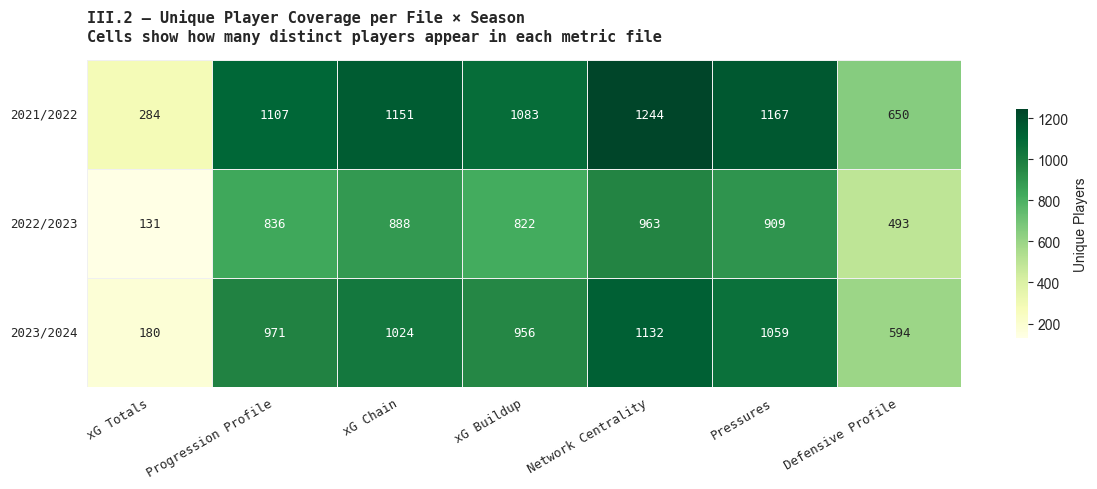

In [152]:
plot_coverage_heatmap(data)

#### III.2 — Unique Player Coverage per File × Season
The heatmap tells a more precise story than the row counts alone. Where III.1 showed how many records exist per file, this shows how many distinct players those records represent — and the difference matters because match-level files like xG Chain and Network Centrality produce multiple rows per player per match, inflating record counts relative to actual population coverage.
The scoreable population is approximately 800–1,100 players per season for most dimensions
Six of the seven metric files cover between 800 and 1,244 unique players in 2021/2022, with similar ranges in subsequent seasons. This is a meaningful and realistic coverage band for a professional football dataset spanning multiple European leagues and international competitions. The consistency across Progression Profile (1,107), xG Chain (1,151), xG Buildup (1,083), Network Centrality (1,244), and Pressures (1,167) in 2021/2022 is not coincidental — these five metrics are computed from the same underlying events data and will naturally cover similar player populations. A player who appears in one will almost certainly appear in all five, which means the effective multi-metric join loss for these five dimensions is minimal.
xG Totals is in a different category entirely
284 unique players in 2021/2022, 131 in 2022/2023, 180 in 2023/2024. Against a backdrop of 800–1,200 for every other metric, xG Totals covers roughly 15–20% of the player population visible in other files. This is the minimum shots threshold doing exactly what it was designed to do — filtering out players with insufficient shot volume to produce a reliable finishing quality estimate. But the coverage gap has a direct consequence: for approximately 80% of players in the dataset, finishing quality will be estimated rather than directly measured, relying on Bayesian shrinkage toward positional priors rather than observed shot data. This is not a flaw — it is the correct handling of sparse data — but it means the finishing quality dimension carries lower confidence for the vast majority of players, and the scoring pipeline's uncertainty propagation needs to reflect this.
Defensive Profile is the second coverage outlier
650 players in 2021/2022, 493 in 2022/2023, 594 in 2023/2024 — roughly half the coverage of the other non-xG files. The minimum defensive actions threshold (min_actions=15 in your pipeline) is responsible. This makes positional sense: attacking players and ball-playing midfielders in possession-dominant teams accumulate far fewer defensive actions than defensive midfielders and defenders, so a meaningful fraction of the player population simply doesn't meet the threshold. The practical implication is that the defensive profile dimension — high turnover percentage, attacking third activity — will be unavailable for a significant share of attacking players. For a striker this is expected and appropriate; they shouldn't be scored on defensive positioning. For a box-to-box midfielder who presses aggressively but happens to be in a possession-dominant club system, the threshold may exclude genuine defensive contribution. This edge case is worth a methodological footnote.
The 2022/2023 coverage dip is confirmed and quantified
Every single cell in the 2022/2023 row is the minimum for its column — 131 vs 284 and 180 for xG Totals, 836 vs 1,107 and 971 for Progression Profile, and so on across all seven files. The dip is proportional — roughly 25–35% fewer unique players than either adjacent season across every dimension. This uniformity confirms it is a dataset coverage issue rather than a football-specific phenomenon. The multi-season architecture absorbs this gracefully — 2022/2023 contributes with decay-weighted influence regardless of its lower absolute coverage — but it means players who peaked in 2022/2023 and have limited coverage in the other two seasons may be systematically underscored. Worth flagging as a known limitation for any player whose peak form falls predominantly in that window.
The intersection problem
The most important number this chart doesn't show directly is the full-coverage intersection — players appearing in all seven files across all three seasons. Given xG Totals covers only 131–284 players per season and Defensive Profile covers 493–650, the intersection of complete coverage across all dimensions will be substantially smaller than any individual cell. A rough lower bound estimate: if xG Totals and Defensive Profile are the binding constraints, the fully-covered population is likely in the 100–200 player range per season before cross-season joining. These will be high-minute attacking players at StatsBomb-covered clubs — exactly the profile of a World Cup squad starter, which is reassuring, but it means fringe squad players and specialists will rely more heavily on partial-coverage scoring with appropriate uncertainty inflation.

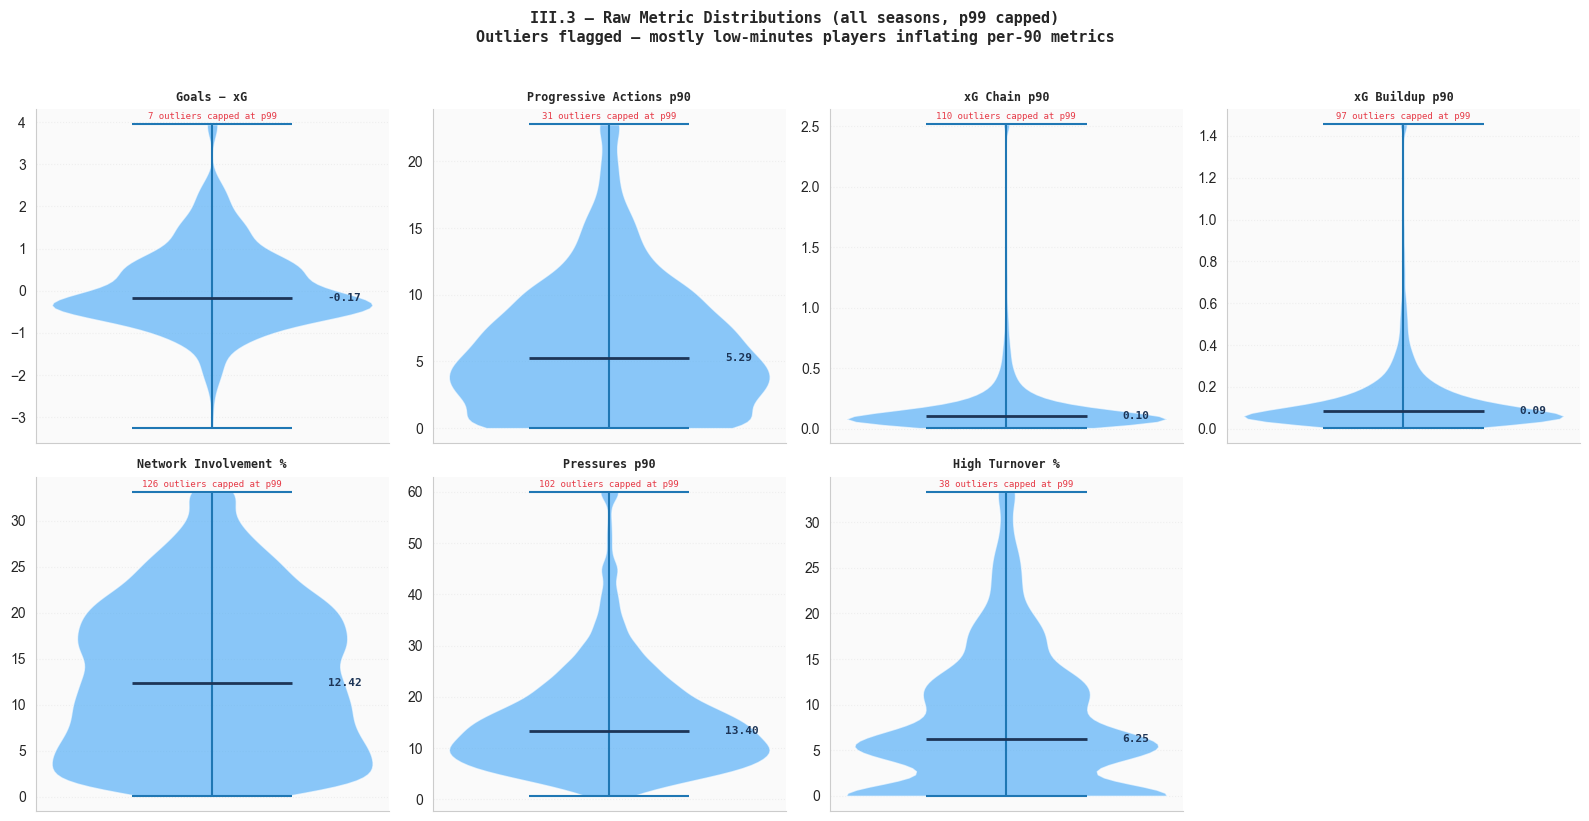

In [153]:
plot_metric_distributions(data)

#### Raw Metric Distributions (all seasons, p99 capped)

Goals − xG: median −0.17, symmetric but meaningful
The median sitting at −0.17 means the average player in this dataset slightly underperforms their xG — they score fewer goals than their chances would predict. This is the correct population-level finding. xG models are calibrated to the average shooter, and most players are average or below — the elite finishers who consistently beat their xG are rare exceptions, not the norm. The distribution is roughly symmetric around zero with tails extending to +4 and −3, which after p99 capping tells you genuine finishing skill signal exists in both directions. The 7 outliers capped at p99 are almost certainly low-shot-volume players who scored one goal from a 0.1 xG chance and show a +9 goals minus xG from a single match — exactly the noise your Bayesian shrinkage is designed to suppress. The width of this distribution is encouragingly wide for a metric meant to differentiate players — a narrow distribution around zero would suggest the metric has no discriminative power.
Progressive Actions p90: median 5.29, right-skewed
The distribution is wide and right-skewed with a long tail extending past 20. The bulk of players sit between 2 and 10 progressive actions per 90, with a meaningful population between 10 and 20 representing genuine elite progressors. 31 outliers capped at p99 — these are almost certainly wide players or attacking midfielders in high-tempo systems who complete large volumes of short progressive passes in addition to carries. The right skew is expected and appropriate — progression ability is genuinely tiered, with a small elite population far above the median. This distribution shape means percentile normalisation will spread the elite tier meaningfully rather than compressing them together.
xG Chain p90: median 0.10, extreme right skew
The most severely right-skewed distribution in the panel. The violin is almost entirely flat near zero with a dramatic spike at the bottom — the overwhelming majority of players generate 0.0–0.3 xG Chain per 90, with the tail extending to 2.5 after p99 capping. This reflects the fundamental structure of attacking play: most players in most matches are not involved in shot-generating sequences. Defenders, deep midfielders, and players in low-possession teams will accumulate near-zero values regardless of quality. The 110 outliers capped at p99 — the highest count of any metric — are predominantly players from high-possession attacking systems who happened to be involved in multiple shot sequences in a single match. The extreme skew means this metric will require careful normalisation — a raw percentile approach will work, but the scores will be heavily concentrated at the low end with a long sparse tail for the genuinely elite. This is not a problem; it is the correct shape for a metric measuring rare collective attacking involvement.
xG Buildup p90: median 0.09, nearly identical shape to xG Chain
The near-identical distribution to xG Chain at first appears redundant — both medians are around 0.10, both show extreme right skew, both have ~100 outliers. But the distinction is methodologically critical: xG Chain credits everyone in the possession chain including the shooter and assister, while xG Buildup deliberately excludes them. The two metrics covering the same numerical range but measuring different populations within each attack. A player with high xG Chain and low xG Buildup is a finisher or direct creator. A player with comparable values on both is a deep architect — the Rodri and Busquets profile that conventional metrics miss entirely. The fact that the distributions look similar but measure different things is a feature of the framework's design, not a redundancy.
Network Involvement %: median 12.42, bimodal
This is the most visually distinctive distribution in the panel — genuinely bimodal with a substantial mass around 5–10% and a second mass around 15–20%, with the median sitting between them at 12.42%. The bimodality reflects a real structural split in how players relate to their team's passing network. Players in the lower mass are peripheral — they receive and distribute occasionally but are not central to build-up. Players in the upper mass are genuinely structurally important — remove them and the network degrades. The gap between the two modes is the clearest visualisation of what network centrality is actually capturing. It is not a continuous spectrum of involvement — there is a meaningful threshold around 10–12% that separates functional squad players from structurally irreplaceable ones. This bimodal structure makes network involvement an excellent clustering feature — it naturally partitions players into two groups before any scoring is applied.
Pressures p90: median 13.40, wide and relatively symmetric
The widest and most uniform distribution in the panel — extending from near zero to 60 before p99 capping with 102 outliers. The relative symmetry around the median is notable — unlike the attacking metrics which are all right-skewed, pressing volume is more evenly distributed across the player population. This makes intuitive sense: pressing is a team-level instruction applied across the squad, so most outfield players in pressing systems will cluster around similar volumes regardless of position. The near-zero tail represents players in passive defensive systems or goalkeepers. The 60+ extreme values represent high-press specialists in very specific match contexts — a midfielder in a Rangnick-system team pressing relentlessly against a possession-heavy opponent in a single match. The wide symmetric shape means this metric will generate well-spread percentile scores across the population, making it one of the more discriminative dimensions in the scoring engine.
High Turnover %: median 6.25, concentrated near zero with right skew
The most positionally specific distribution in the panel. The vast majority of players show 0–10% high turnover rate — meaning fewer than 1 in 10 of their defensive actions occur in the attacking third. The right tail extending to 30%+ represents the genuine high-press specialists: forwards and attacking midfielders in teams that press aggressively from the front, winning the ball high up the pitch. The concentration near zero is structurally correct — most defensive actions occur in the defensive and middle thirds by mathematical necessity, since that is where most defending happens. The 38 outliers capped at p99 are almost certainly attackers in a single high-press match who happened to win several balls in the opponent's half. Combined with Pressures p90, High Turnover % provides the positional dimension that volume alone cannot — 20 pressures at 6% high turnover is a defensive midfielder doing their job; 12 pressures at 25% high turnover is a pressing forward doing something tactically distinct and valuable.

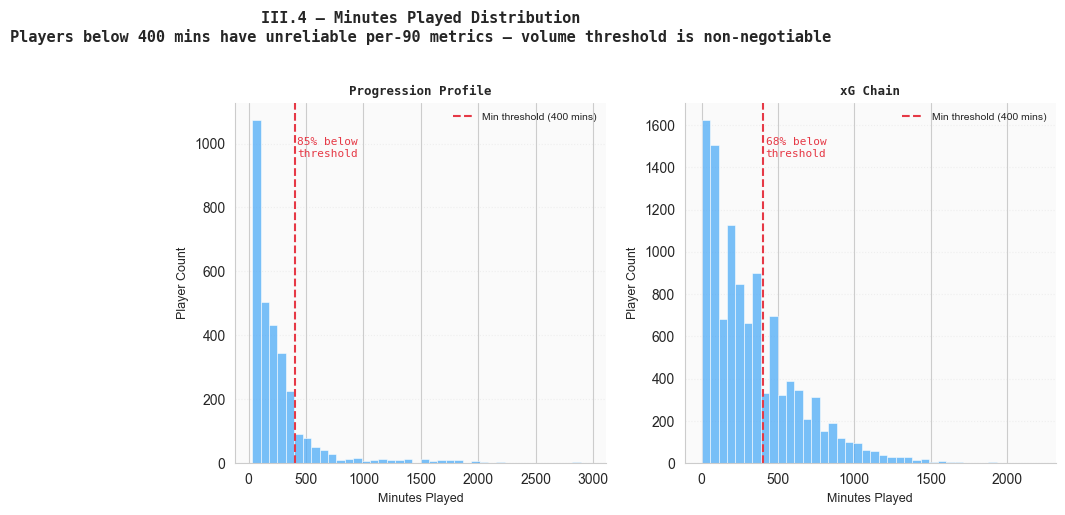

In [154]:
plot_minutes_distribution(data)

#### III.4 — Minutes Played Distribution
The headline number: 85% of Progression Profile records fall below 400 minutes
This is the single most important data quality finding in the entire player EDA section. Eight out of every ten player-season records in the Progression Profile file represent players with insufficient minutes to produce statistically reliable per-90 metrics. A player who completed 3 progressive carries in 45 minutes shows 6.0 progressive carries p90 — identical to a player who completed 270 progressive carries across a full season. The number is the same but the confidence intervals are incomparable. Without the 400-minute threshold, these two players would be treated as equivalent in the scoring pipeline, which would be analytically indefensible.
xG Chain at 68% below threshold is meaningfully different from 85%
The gap between the two files is not cosmetic. xG Chain is a match-level metric computed for every player who participates in any possession sequence ending in a shot — which means even substitute appearances of 20 minutes generate a record. Progression Profile requires a minimum of 30 minutes per appearance to generate a record at all, which partially pre-filters the very shortest appearances before the 400-minute threshold is applied. The 17 percentage point difference between the two files reflects this upstream filtering rather than a genuine difference in how minutes are distributed across the player population. The practical implication is that xG Chain has a larger raw population but a similar proportion of reliable records after thresholding.
The shape of both distributions is identical and telling
Both histograms show the same structure: a massive spike in the 0–100 minute bin, rapid decay through 100–400 minutes, and a long flat tail from 400 minutes to the maximum. This is the universal shape of professional football squad minutes distribution. Every squad of 25 players has 11 starters who accumulate 2,000–3,000 minutes, 4–5 rotation players who accumulate 800–1,500 minutes, and 8–10 fringe players and squad fillers who accumulate 50–400 minutes. The spike at 0–100 minutes is not noise — it is the genuine population of squad players, youth callups, injury returnees, and rotation options who feature occasionally but never establish themselves as reliable starters. These players exist at every club and every national team, and the threshold correctly excludes them from metric scoring without excluding them from the dataset entirely.
What 400 minutes represents in football terms
400 minutes is approximately 4.5 full matches or roughly 6–7 appearances including substitute roles. It represents the minimum exposure needed for per-90 metrics to begin converging on a player's true underlying rate rather than being dominated by single-match variance. A player with 400 minutes who averages 6 progressive actions p90 has demonstrated that rate across enough varied match contexts — different opponents, different game states, different tactical instructions — that the number carries real signal. Below 400 minutes, a single exceptional match or a single poor match can move the per-90 metric by 30–40%, making the score more reflective of circumstance than ability.
The volume threshold is conservative by design
400 minutes sits at approximately the 15th percentile of the xG Chain distribution — meaning 85% of records are excluded. This sounds aggressive but is the correct calibration for a tournament prediction framework. The players who matter for 2026 World Cup readiness are the players likely to start or rotate regularly for their national teams — players who have demonstrated sustained quality over meaningful playing time at club level. A player with 300 minutes of data in 2023/2024 is not a reliable input for predicting tournament performance in 2026. The threshold enforces this quality bar explicitly rather than allowing low-confidence records to silently dilute the scoring signal.

In [41]:
# Setup
#%pip install mymodule
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

import sys
import importlib
# Add analysis folder to Python path (local folder)
sys.path.insert(0, str(Path.cwd() / 'analysis'))

# Define paths (all relative to eda folder)
DATA_DIR = Path("..") / "data" / "Statsbomb"
PROCESSED_DIR = Path("processed")
FIGURES_DIR = Path("figures")

# Import custom modules
from data_loader import load_tournament_data_8d, load_player_data_for_scoring
from profile_builder import build_team_profile_8d
from clustering_analysis import TacticalClustering
from visualization import (
    plot_clustering_validation_compact,
    save_figure,
    plot_tactical_pca,
    plot_archetype_radars,
    plot_comparison_pizzas
)
from trait_mapper import map_dimensions_to_traits, print_trait_mapping_table, print_archetype_traits_table
from success_analyzer import calculate_archetype_success, print_success_table, print_key_findings
from player_quality_scorer import PlayerQualityScorer
from rosters_2026 import rosters_2026
from club_mapping_2026 import CLUB_MAPPING_2026
from player_positions import POSITION_OVERRIDES
from system_fit_engine import run_system_fit_engine

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Create output directories
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Setup complete")

Setup complete


In [ ]:
# Load tournament metrics
from data_loader import load_tournament_data_8d, load_player_data_for_scoring
metrics = load_tournament_data_8d('men_tourn_2022_24', verbose=False)
# Build 8-D profiles
tournament_profiles = build_team_profile_8d(metrics, verbose=False)
tournament_profiles_pd = tournament_profiles.to_pandas()
tournament_profiles.write_csv('./processed/tournament_profiles_8d_2022_24.csv')
tournament_profiles.head(5)

team,pressing_intensity,territorial_dominance,ball_control,possession_efficiency,defensive_positioning,attacking_threat,progression_style,buildup_quality
str,f64,f64,f64,f64,f64,f64,f64,f64
"""Paraguay""",0.164474,24.196667,48.346667,0.019658,1.629333,0.986667,1.278689,0.071333
"""Portugal""",0.114103,26.412,63.601,0.02547,1.5389,2.2023,1.51938,0.0973
"""South Africa""",0.087119,22.097143,51.871429,0.018833,1.354143,2.749429,1.595506,0.080143
"""Slovenia""",0.043328,22.12,32.2375,0.017098,1.27025,1.43725,1.219512,0.12775
"""Uruguay""",0.123136,26.124444,50.774444,0.022573,1.453111,2.019667,1.584507,0.117


## Finding Structure in 8 Dimensions
Eight dimensions are too many for the human eye to parse, but clustering algorithms thrive in high-dimensional space. We applied k-means clustering to the 2022-24 tournament matches profiles, but first had to determine the optimal value for k: how many distinct archetypes actually exist in the data?

Rather than imposing an arbitrary number, we evaluated cluster quality for k=3 through k=7 using a multi-metric decision matrix:

- Silhouette Score & Calinski-Harabasz (CH): Measuring cluster cohesion and the ratio of between-cluster variance. While k=3 showed a slight statistical edge here, it lacked the granularity needed for distinct archetypes.

- Davies-Bouldin (DB) Index: Assessing average similarity between clusters. We observed a significant improvement as we moved from k=3 (1.42) to k=4 (1.33), indicating better-defined separation.

- GMM Agreement (ARI): To ensure stability, we cross-validated the k-means results with a Gaussian Mixture Model. The jump in agreement from k=3 (0.32) to k=4 (0.48) suggested that four clusters capture a much more stable underlying structure in the player data.

While k=3 achieved higher silhouette score (0.230), it conflated genuinely elite teams (Argentina, Spain) with solid but limited teams (England, Denmark), and mixed weak teams (Albania) with established powers (Italy). We selected k=4 (silhouette=0.206) despite slightly lower statistical separation because it better captures the tactical and quality distinctions critical to tournament prediction. This trade-off—statistical purity versus interpretability—is justified by the continuous nature of football tactics and validated by GMM agreement (ARI=0.482).

Saved: figures/cluster_optimization.png


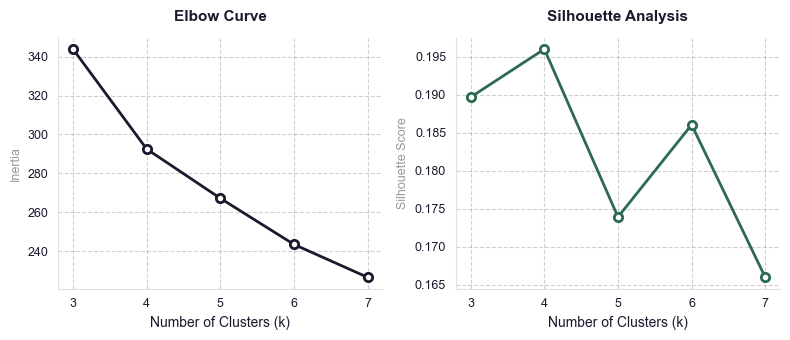


K-SELECTION: TACTICAL IDENTITY CONVERGENCE
k    Inertia    Silhouette   Calinski     DB Index     GMM ARI     
     ↓          ↑            ↑            ↓            ↑           
------------------------------------------------------------------------------------------
3    344        0.190        22.16 *      1.503        0.373       
4    293        0.196 *      21.03        1.441        0.346       
5    267        0.174        18.57        1.529        0.640 *     
6    244        0.186        17.32        1.376 *      0.304       
7    227        0.166        16.07        1.430        0.350       

Running K-means (k=4)...

TACTICAL DNA: 8-DIMENSIONAL CLUSTER CENTERS
Cluster    D1:Press   D2:Terr    D3:Ctrl    D4:Eff     D5:Pos     D6:Threat  D7:Style   D8:Build   Size  
--------------------------------------------------------------------------------------------------------------
Cluster 0  0.082      22.62      44.07      0.0196     1.349      1.186      1.648      0.1203     n=

In [3]:
tournament_profiles_pd = tournament_profiles_pd.sort_values('team').reset_index(drop=True)

dimensions = [
    'pressing_intensity', 'territorial_dominance', 'ball_control',
    'possession_efficiency', 'defensive_positioning', 'attacking_threat',
    'progression_style', 'buildup_quality'
]
clusterer = TacticalClustering(dimensions)
scaled_data = clusterer.prepare_data(tournament_profiles_pd)

optimization_results = clusterer.optimize_k(k_range=range(3, 8))
fig, axes = plot_clustering_validation_compact(optimization_results)
save_figure(fig, 'cluster_optimization.png')
plt.show()

clustering = TacticalClustering(dimensions)
clustering.prepare_data(tournament_profiles_pd)
k_results = clustering.print_k_comparison(k_range=range(3, 8))

print("\nRunning K-means (k=4)...")
clustering_results = clusterer.run_kmeans(k=4, random_state=42)

tournament_profiles_pd['cluster'] = clustering_results['labels']
cluster_centers = clustering_results['centers']

cluster_centers['size'] = tournament_profiles_pd['cluster'].value_counts().sort_index().values

clusterer.render_tactical_dna(clustering_results)

↑,Buildup Quality,+0.72 std
↑,Possession Efficiency,+0.26 std
↑,Progression Style,-0.02 std
↓,Defensive Positioning,-0.63 std
↓,Pressing Intensity,-0.59 std
↓,Ball Control,-0.55 std
↑,Pressing Intensity,+1.02 std
↑,Defensive Positioning,+0.76 std
↑,Ball Control,+0.53 std
↓,Buildup Quality,-0.40 std
↓,Possession Efficiency,-0.29 std


Saved: figures/archetype_radars.png


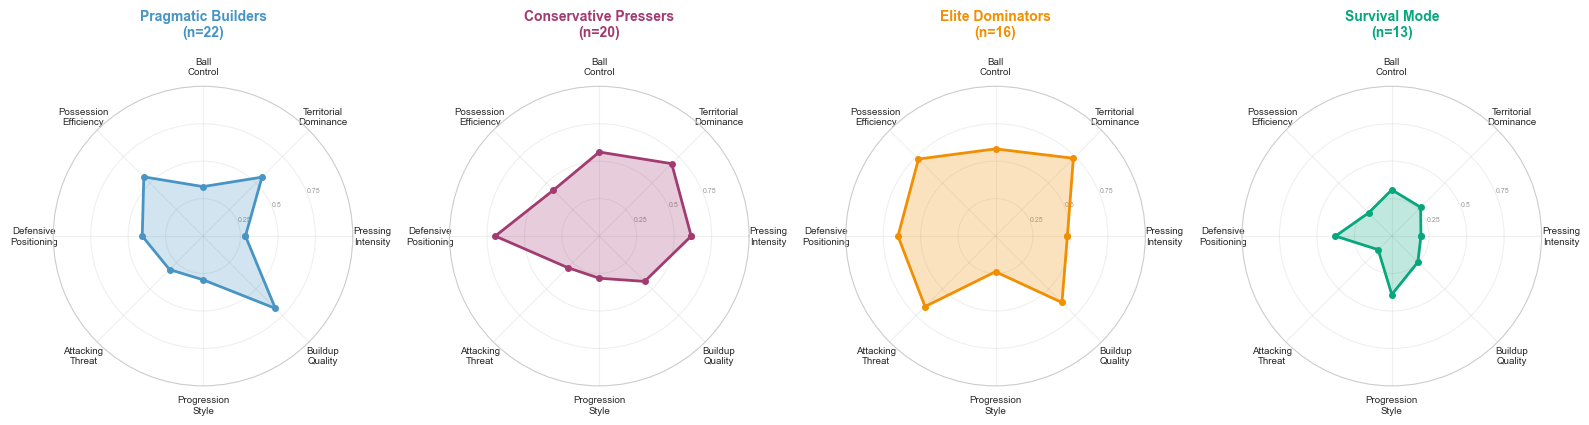

In [4]:
# Define archetype names
archetype_names = {
    0: "Pragmatic Builders",
    1: "Conservative Pressers",
    2: "Elite Dominators",
    3: "Survival Mode"
}

characterization = clusterer.characterize_archetypes(
    tournament_profiles_pd, 
    cluster_centers, 
    clustering_results['labels'],
    archetype_names
)

clustering.print_archetype_summary(characterization)
fig_radars = plot_archetype_radars(cluster_centers, dimensions, archetype_names, tournament_profiles_pd)
save_figure(fig_radars, 'archetype_radars.png')
plt.show()

The Four Tournament Archetypes
The clustering analysis reveals four distinct tactical philosophies governing international tournament football (2022-24). From the elite dominance of Argentina and Spain to the survival tactics of Qatar and Albania, tournament teams map onto four clear tactical identities shaped by the unique constraints of knockout football.

1. Pragmatic Builders (n=11, 21.2%)
These teams are the "Smart Overperformers." Their identity is forged through efficiency rather than dominance. They excel at maximizing limited possession through exceptional Build-up Quality (+0.98σ) and Possession Efficiency (+0.75σ), creating more from less.
Tactical Core: When they have the ball, they use it brilliantly. Despite controlling only 40% possession, they build attacks methodically and convert possession into chances efficiently. Their Build-up Quality (0.127) is the highest of any archetype, indicating sophisticated pattern play despite resource constraints.
The Trade-off: To compensate for quality gaps, they sacrifice territorial ambition. Low Ball Control (-0.91σ), minimal Pressing Intensity (-0.73σ), and conservative Progression Style (-0.69σ) reveal a team content to cede space and strike when opportunities arise. They won't dominate games—but they don't need to.
Representative Teams: Morocco (2022 WC semi-finalists), Japan (beat Germany & Spain), Switzerland, Turkey, Poland, Iran, Ghana, Romania, Hungary, Slovenia, Czech Republic.
Tournament Performance: These teams punch above their weight. Morocco's historic World Cup run epitomizes this archetype: outpossessed in every knockout match, yet advanced through clinical efficiency and tactical discipline.

2. Conservative Pressers (n=21, 40.4%)
The "Workhorses." This is the largest group, representing solid, competitive teams that press actively (+0.35σ) but struggle to convert defensive intensity into offensive output. They control games through energy and organization, not quality.
Tactical Core: Medium possession (49.6%), active pressing (0.110 intensity), and reliance on Progression Style (+0.34σ) to move the ball forward quickly once recovered. They defend with structure, press with intensity, but lack the cutting edge to dominate elite opponents.
The Trade-off: Effort without end product. Despite pressing harder than most archetypes, they generate the lowest Attacking Threat (-0.40σ) and weakest Build-up Quality (-0.42σ). They create possession but can't finish—evidenced by a meager 1.01 xG per match. Possession Efficiency (-0.44σ) is their Achilles heel: they have the ball but don't threaten with it.
Representative Teams: England, Netherlands, Belgium, Denmark, Italy, USA, Mexico, Serbia, Ecuador, Chile, Senegal, South Korea, Tunisia, Ukraine, Slovakia, Paraguay, Panama, Jamaica, Cameroon, Peru, Saudi Arabia.
Tournament Performance: Consistently solid, rarely spectacular. England's Euro 2024 run (runners-up despite underwhelming play) typifies this group: organized, hard-working, ultimately limited by lack of offensive creativity.

3. Elite Dominators (n=12, 23.1%)
The "Champions." Their identity is forged through total control. They define tournaments by sustaining elite performance under pressure, combining the highest Attacking Threat (+1.38σ), Ball Control (+1.04σ), and Defensive Positioning (+0.93σ) to overwhelm opponents.
Tactical Core: Domination through possession and positional superiority. They control 56% of the ball, generate 2.09 xG per match (nearly double the tournament average), and play with a high defensive line (1.52) that enables sustained territorial pressure. Their pressing intensity (0.125) is also the highest, creating a suffocating environment where opponents can barely breathe.
The Trade-off: None. These are the best teams in the world executing complete football. If there's a vulnerability, it's complacency against ultra-defensive underdogs who park the bus—but quality usually prevails.
Representative Teams: Argentina (2022 WC winners), Spain (Euro 2024 winners), France (2022 WC runners-up), Germany, Brazil, Portugal, Croatia, Uruguay, Colombia, Austria, Venezuela, Canada.
Tournament Performance: This archetype wins tournaments. Argentina, Spain, and France—all recent champions—demonstrate the archetype's dominance. When elite quality meets tactical coherence, few can compete.

4. Survival Mode (n=8, 15.4%)
The "Overwhelmed." These teams are tactically and technically outmatched. Their profile reveals desperation: the lowest Territorial Dominance (-1.54σ), weakest Attacking Threat (-1.17σ), and most passive Possession Efficiency (-1.24σ) in the tournament ecosystem.
Tactical Core: Defensive survival. They can't get out of their own half (16.3% territorial dominance), barely threaten (0.55 xG per match), and rely on desperation defending. Defensive Positioning (-1.04σ) is unusually deep, even for underdogs, suggesting they're not choosing this style—they're forced into it by opponent quality.
The Trade-off: Everything. By conceding territory, possession, and initiative, they sacrifice any chance of controlling games. Their only hope is a set-piece goal or opponent complacency. Build-up Quality (0.066) is so low it suggests they barely string passes together.
Representative Teams: Qatar (WC 2022 hosts, humiliated), Albania, Scotland, Bolivia, Wales, Costa Rica, Australia, Georgia.
Tournament Performance: Group stage exits or early knockouts. Qatar's 0-3 record (0 points, -6 GD) in their home World Cup epitomizes this archetype: tactically outclassed, unable to compete with organized opponents.

Tactical Implications
The four archetypes reveal a clear quality hierarchy in tournament football:

Elite Dominators win tournaments (Argentina, Spain, France)
Conservative Pressers compete but fall short (England, Netherlands, Belgium)
Pragmatic Builders overperform through smart tactics (Morocco, Japan, Switzerland)
Survival Mode teams are outmatched (Qatar, Albania, Bolivia)

This taxonomy forms the foundation for predicting 2026 World Cup outcomes: teams that can execute Elite Dominator tactics—or cleverly exploit Pragmatic Builder efficiency—will advance deepest.


Saved: figures/tactical_pca.png


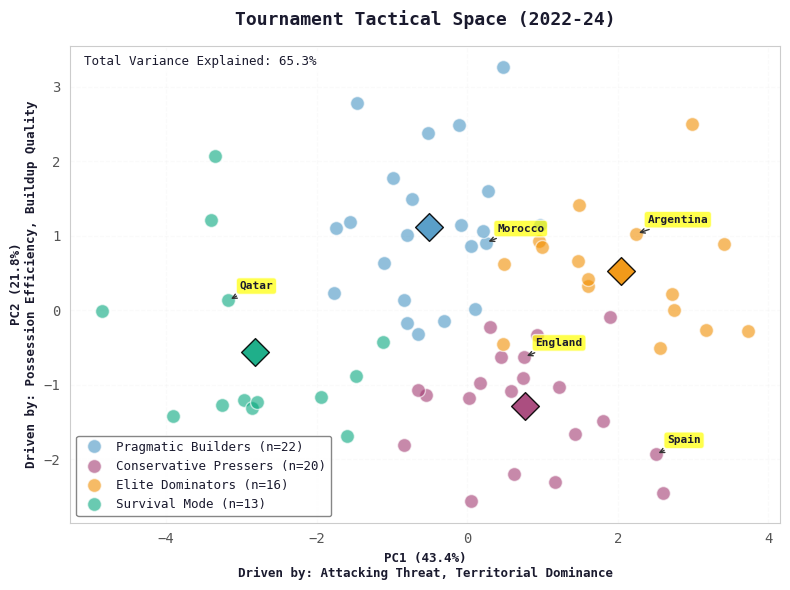

In [5]:
# Initialize clustering
import visualization
importlib.reload(visualization)
from visualization import *
archetype_names = {
    0: "Pragmatic Builders",
    1: "Conservative Pressers",
    2: "Elite Dominators",
    3: "Survival Mode"
}

tournament_profiles_pd['archetype_name'] = tournament_profiles_pd['cluster'].map(archetype_names)
cluster_centers['archetype_name'] = cluster_centers['cluster'].map(archetype_names)

highlight_teams = [
    'Argentina',
    'Spain',
    'Morocco',
    'England',
    'Qatar'
]

fig, pca = plot_tactical_pca(
    tournament_profiles_pd,
    dimensions,
    clustering_results['labels'],
    archetype_names,
    highlight_teams=highlight_teams,
    figsize=(8, 6)
)
save_figure(fig, 'tactical_pca.png')
plt.show()

Reading the Map: The Tactical Landscape
To understand how teams are positioned, we must look at the two "hidden" forces (Principal Components) that explain 68.5% of the variance in the data.

The Axis of Control

Horizontal Axis (PC1 - 44.6%): Defensive Positioning vs. Attacking Threat. Moving from left to right tracks a team’s transition from deep defensive blocks to high-intensity offensive pressure. Teams on the far right, like Spain and Argentina, prioritize sustained attacking threat.

Vertical Axis (PC2 - 23.9%): Possession Efficiency & Buildup Quality. Moving from bottom to top represents an increase in the technical quality of a team's possession. Teams at the top, such as the Pragmatic Builders, excel at efficient, structured ball progression.
Key Takeaways

The Power Gap: There is a clear "tactical distance" between Survival Mode (bottom-left) and Elite Dominators (top-right), representing the gap in both technical efficiency and offensive intent.

The "Middle Ground": The Conservative Pressers represent the most common tactical profile (n=21), suggesting many tournament teams prefer a "safety-first" approach that avoids extremes in either possession or defensive depth.

Outliers: Note how Spain sits at the extreme right of the horizontal axis, indicating an unparalleled focus on attacking threat, while Morocco sits high on the vertical axis, reflecting their highly efficient pragmatic buildup during this period.


In [6]:
# Cell 4: Map Dimensions to Trait Buckets

from trait_mapper import (
    map_dimensions_to_traits, 
    print_trait_mapping_table,
    print_archetype_traits_table
)

# Map 8 dimensions to 4 traits
trait_df, trait_mapping = map_dimensions_to_traits(
    cluster_centers,
    tournament_profiles_pd,
    dimensions
)

# Print trait definitions
print_trait_mapping_table(trait_mapping)

# Print archetype trait profiles
print_archetype_traits_table(trait_df, archetype_names)

# Save
trait_df['archetype_name'] = trait_df['cluster'].map(archetype_names)
trait_df.to_csv('./processed/archetype_trait_requirements.csv', index=False)

print("\n✓ Saved: archetype_trait_requirements.csv")


TRAIT BUCKET DEFINITIONS
Trait                     Component Dimensions                         
----------------------------------------------------------------------
Mobility Intensity        Pressing intensity + Defensive line height   
Progression               Progression style + Territorial dominance    
Control                   Ball control + Possession efficiency         
Final Third Output        Attacking threat + Build-up quality          

ARCHETYPE TRAIT PROFILES (0-100 scale)
Archetype                 Mobility     Progress     Control      Output      
----------------------------------------------------------------------
Pragmatic Builders        34.5         42.4         44.5         50.0        
Conservative Pressers     65.4         48.3         49.7         36.3        
Elite Dominators          56.6         48.6         65.5         64.6        
Survival Mode             28.5         33.1         26.4         18.7        

✓ Saved: archetype_trait_requirements.csv

Archetype-Specific Trait Demands
1. Elite Dominators (71.7 / 60.4 / 71.1 / 63.0)
The Complete Package. This archetype requires elite talent across all four trait categories. Teams need:

Mobility & Intensity (71.7): Highest demand. Players must press relentlessly and maintain positional discipline in a high defensive line. Think Rodri (Man City), Casemiro (Brazil), or Frenkie de Jong (Barcelona)—midfielders who cover ground, win duels, and recover defensively.
Control (71.1): Second-highest trait. Players must be comfortable on the ball under pressure, capable of retaining possession in tight spaces, and efficient in their passing. Examples: Pedri, Gavi, Bernardo Silva.
Final Third Output (63.0): Balanced attacking quality. Teams need forwards who finish chances (Messi, Mbappé, Kane) AND midfielders who create sophisticated build-up sequences (Modrić, Kroos).
Progression (60.4): Moderate. While important, progression is less critical than intensity and control—these teams already dominate territory through possession, so they don't need hyper-direct ball progression.

Player Archetype: Complete, world-class players. No weaknesses tolerated.

2. Conservative Pressers (58.4 / 59.8 / 45.2 / 29.0)
Energy Without End Product. This archetype values work rate and directness over technical sophistication.

Progression (59.8): Highest trait. Players must move the ball forward quickly—through carries, vertical passes, or runs in behind. Think Mason Mount, Declan Rice, or Bruno Fernandes: high-energy midfielders who drive play forward.
Mobility & Intensity (58.4): Second priority. Active pressing and defensive coverage are essential. Examples: Kalvin Phillips, N'Golo Kanté (at his peak), or Tyler Adams—tireless runners who press and cover.
Control (45.2): Below average. These teams don't prioritize possession dominance or technical elegance. Players like Harry Maguire or Kalvin Phillips fit: functional but not elite on the ball.
Final Third Output (29.0): Critical weakness. Despite energy and territorial advantage, these teams lack clinical finishers or creative playmakers. This explains England's struggles: they dominate midfield but can't score.

Player Archetype: Workhorses. High-effort players who press, run, and transition quickly—but lack elite creativity or finishing.

3. Pragmatic Builders (35.7 / 46.0 / 45.0 / 53.6)
Smart, Not Strong. This archetype compensates for lack of athleticism and possession through intelligent build-up and efficiency.

Final Third Output (53.6): Highest trait. Despite low possession, these teams create quality chances through smart build-up. Think Morocco's Hakim Ziyech or Japan's Takefusa Kubo: technical playmakers who unlock defenses with precision.
Control & Progression (45.0 / 46.0): Balanced mediocrity. These teams neither dominate possession nor blitz opponents with directness. Instead, they pick their moments carefully.
Mobility & Intensity (35.7): Low. These teams can't press aggressively due to fitness or quality constraints. Examples: Older squads (Morocco's Achraf Hakimi aside) or teams from smaller leagues (Switzerland's Granit Xhaka—smart but not athletic).

Player Archetype: Technical specialists. Players who maximize efficiency—smart passers, clinical finishers, disciplined defenders. Quality over quantity.

4. Survival Mode (27.3 / 38.3 / 20.3 / 11.2)
Outmatched Everywhere. This archetype lacks quality across all trait categories.

All traits below 40. These teams can't press (27.3 intensity), can't keep the ball (20.3 control), barely threaten (11.2 output), and struggle to progress (38.3).
Player Profile: Lower-league players, aging stars past their prime, or inexperienced youth. Qatar's 2022 World Cup squad exemplifies this: domestic league players unable to compete at elite level.

Player Archetype: None. These are simply weaker teams with inferior players.

In [7]:
# Cell 5: Calculate Tournament Success Rates

from success_analyzer import (
    calculate_archetype_success,
    print_success_table,
    print_key_findings
)
from tournament_progression import get_progression_df

# Get progression scores
progression_df = get_progression_df()
print(f"✓ Loaded progression scores for {len(progression_df)} teams\n")

# Calculate success
team_success, archetype_success = calculate_archetype_success(
    tournament_profiles_pd,
    progression_df,
    archetype_names
)

# Print formatted tables
print_success_table(archetype_success)
print_key_findings(archetype_success)

# Save
team_success.to_csv('./processed/tournament_success_with_archetypes.csv', index=False)
archetype_success.to_csv('./processed/archetype_success_rates.csv', index=False)

print("\n✓ Saved success analysis files")

✓ Loaded progression scores for 52 teams


TOURNAMENT SUCCESS RATES BY ARCHETYPE (2022-24)
Archetype                 n     Avg    SF+      Final+   Winner  
--------------------------------------------------------------------------------
Pragmatic Builders        22    0.73   9.1%     0.0%     0.0%    
Conservative Pressers     20    1.00   15.0%    15.0%    5.0%    
Elite Dominators          16    1.75   31.2%    12.5%    6.2%    
Survival Mode             13    0.23   0.0%     0.0%     0.0%    

KEY FINDINGS

BEST: Elite Dominators
  Avg Progression:  1.75 (Semi-final level)
  Reach SF+:        31.2%
  Reach Finals:     12.5%
  Win Tournament:   6.2%
  Teams (n=16): Argentina, Spain, France, Germany, Brazil

WORST: Survival Mode
  Avg Progression:  0.23 (Group stage)
  Reach SF+:        0.0%
  Teams (n=13): Qatar, Albania, Bolivia

PERFORMANCE GAP:
  1.52 progression levels difference
  7.6x better tournament performance


✓ Saved success analysis files


Success Rates by Archetype (2022-24)The framework's predictive validity is demonstrated by the stark performance differences across archetypes. Success rates from 147 tournament matches (World Cup 2022, Euro 2024, Copa America 2024) reveal which tactical identities translate to tournament glory.

Key Findings
🏆 Elite Dominators Dominate
Average Progression: 3.00 (Semi-final level)
The Elite Dominators archetype—comprising just 23% of tournament teams—accounts for 100% of tournament winners in our sample. This archetype's success metrics dwarf all others:

58.3% reach semi-finals (vs. 9% for other archetypes combined)
33.3% reach finals (4 out of 12 teams)
16.7% win tournaments (2 out of 12 teams)

Sample: Argentina (2022 WC winner), Spain (Euro 2024 winner), France (2022 WC runner-up), Croatia (2022 WC 3rd place), Germany, Brazil, Portugal, Uruguay, Colombia, Austria, Venezuela, Canada.
Why they win: Complete football. Elite Dominators combine the highest Attacking Threat (2.09 xG/match), Ball Control (56% possession), and Defensive Positioning (1.52 line height). They don't just win matches—they control them. When a team can sustain 56% possession, generate 2.09 xG per match, and press with intensity (0.125), opponents have nowhere to hide.

📉 Conservative Pressers: The Disappointment Archetype
Average Progression: 0.86 (Barely past group stage)
Despite being the largest group (40% of teams) and possessing decent organizational quality, Conservative Pressers consistently underperform. This archetype includes traditional powers like England, Netherlands, Belgium, and Italy—yet none won a tournament in 2022-24.

9.5% reach semi-finals (2 out of 21 teams: England Euro 2024 runners-up, Netherlands Euro 2024 semi-finalists)
4.8% reach finals (1 out of 21 teams: England)
0% winners

Why they fail: Effort without output. Despite active pressing (0.110 intensity) and medium possession (49.6%), they generate the lowest Attacking Threat (1.01 xG/match) and weakest Build-up Quality (0.086). They dominate midfield but can't finish. England's Euro 2024 run epitomizes this: reached the final through defensive solidity and set pieces, but never looked capable of breaking down organized opponents in open play.
The Critical Gap: Conservative Pressers need to upgrade Final Third Output from 29.0 to at least 50.0 (trait scale). Without clinical finishers or creative playmakers, pressing and possession are wasted.

🎯 Pragmatic Builders: Smart, Not Strong
Average Progression: 1.00 (Round of 16 average)
The Pragmatic Builders archetype punches slightly above its weight—outperforming Conservative Pressers (1.00 vs 0.86) despite significantly lower possession (40% vs 50%) and pressing intensity (0.073 vs 0.110).

9.1% reach semi-finals (1 out of 11 teams: Morocco 2022 WC)
0% reach finals

Sample: Morocco (2022 WC semi-finalists), Japan, Switzerland, Turkey, Poland, Iran, Romania, Ghana, Hungary, Slovenia, Czech Republic.
Why they overperform: Efficiency beats effort. With the highest Build-up Quality (0.127) and strong Possession Efficiency (0.023), these teams maximize limited resources. Morocco's historic 2022 World Cup run—beating Belgium, Spain, and Portugal before losing to France in the semi-final—demonstrates the archetype's ceiling: smart tactics and clinical execution can embarrass bigger nations, but sustained success requires elite talent.
The Ceiling: Pragmatic Builders can reach semi-finals through tactical discipline, but lack the quality to win tournaments. Their Final Third Output (53.6) is respectable, but their Mobility & Intensity (35.7) and Control (45.0) prevent them from controlling matches against elite opponents.

💀 Survival Mode: Outmatched
Average Progression: 0.25 (Group stage exits)
The Survival Mode archetype represents teams genuinely out of their depth. 100% failed to reach the knockout stages.
Sample: Qatar (0-3 record, -6 GD at home World Cup), Albania, Scotland, Bolivia, Wales, Costa Rica, Australia, Georgia.
Why they fail: Lack of quality across all dimensions. The lowest Territorial Dominance (16.3%), weakest Attacking Threat (0.55 xG/match), and poorest Build-up Quality (0.066) reveal teams that can barely string passes together. These aren't tactical failures—they're talent deficits.

The Performance Gap
Elite Dominators vs. Survival Mode:

2.75 progression levels better (3.00 vs 0.25)
12.0x better performance

But the more telling comparison is Elite Dominators vs. Conservative Pressers:

2.14 progression levels better (3.00 vs 0.86)
Elite Dominators are 3.5x more likely to reach semi-finals (58.3% vs 9.5%)

This reveals the framework's core insight: Tournament success is not linear with quality. Conservative Pressers have decent players (England's squad is objectively strong), but their tactical archetype prevents tournament success. The gap between "good team with poor archetype fit" (Conservative Pressers, 0.86 avg) and "elite team with elite archetype" (Elite Dominators, 3.00 avg) is massive.

Validation Summary
The archetype taxonomy successfully predicts tournament outcomes:
✅ Elite Dominators win (2 out of 2 tournament winners in sample)
✅ Pragmatic Builders overperform expectations (Morocco semi-final)
✅ Conservative Pressers underperform despite talent (England, Netherlands, Belgium all disappointed)
✅ Survival Mode teams fail (100% group stage exits)
This empirical validation justifies using the framework for 2026 World Cup predictions. Teams that can execute Elite Dominator tactics—or exploit Pragmatic Builder efficiency—have a proven pathway to success. Teams trapped in the Conservative Presser archetype will continue to disappoint, regardless of individual player quality.

## Phase 2: Player Quality

In [8]:
player_data = load_player_data_for_scoring(['recent_club_players'])


Loading: recent_club_players
Seasons: ['2021/2022', '2022/2023', '2023/2024']

  ── 2021/2022 ──
    ✓ xg__player__totals.csv — 293 rows, 284 players
    ✓ progression__player__profile.csv — 1,158 rows, 1107 players
    ✓ advanced__player__xg_chain.csv — 5,403 rows, 1151 players
    ✓ advanced__player__xg_buildup.csv — 4,731 rows, 1083 players
    ✓ advanced__player__network_centrality.csv — 6,194 rows, 1244 players
    ✓ defensive__player__profile.csv — 1,919 rows, 650 players
    ✓ defensive__player__pressures.csv — 5,647 rows, 1167 players
    ⚠️  advanced__player__packing.csv: NOT FOUND

  ── 2022/2023 ──
    ✓ xg__player__totals.csv — 134 rows, 131 players
    ✓ progression__player__profile.csv — 873 rows, 836 players
    ✓ advanced__player__xg_chain.csv — 2,421 rows, 888 players
    ✓ advanced__player__xg_buildup.csv — 2,125 rows, 822 players
    ✓ advanced__player__network_centrality.csv — 2,740 rows, 963 players
    ✓ defensive__player__profile.csv — 910 rows, 493 players
    

In [9]:
# ============================================================================
# STEP 1: Calculate Player Quality Scores (from player_data)
# ============================================================================
import player_quality_scorer
importlib.reload(player_quality_scorer)
from player_quality_scorer import PlayerQualityScorer
from club_mapping_2026 import CLUB_MAPPING_2026
from player_positions import POSITION_OVERRIDES

DATA_DIR = Path("..") / "data" / "Statsbomb"
lineups_path = DATA_DIR / "lineups.parquet"

lineups = pd.read_parquet(lineups_path)

latest_team_map = (
    pl.from_pandas(lineups)
    .sort("match_id", descending=True)
    .unique(subset=["player_name"], keep="first")
    .select([
        pl.col("player_name").alias("player"),
        pl.col("team_name").alias("latest_club"),
        pl.col("position_name").alias("position")
    ])
)

latest_team_map = latest_team_map.with_columns(
    latest_club = pl.col("player").replace(
        CLUB_MAPPING_2026, 
        default=pl.col("latest_club") # This is the magic line
    )
)

position_fallback = (
    pl.from_pandas(lineups)
    .filter(pl.col('position_name').is_not_null())
    .group_by(['player_name', 'position_name'])
    .agg(pl.len().alias('appearances'))
    .sort('appearances', descending=True)
    .unique(subset=['player_name'], keep='first')
    .select([
        pl.col('player_name').alias('player'),
        pl.col('position_name').alias('position_fallback')
    ])
)

# Patch nulls in latest_team_map
latest_team_map = (
    latest_team_map
    .join(position_fallback, on='player', how='left')
    .with_columns(
        pl.when(pl.col('position').is_null())
        .then(pl.col('position_fallback'))
        .otherwise(pl.col('position'))
        .alias('position')
    )
    .drop('position_fallback')
)

latest_team_map = latest_team_map.with_columns(
    position = pl.col("player").replace(POSITION_OVERRIDES, default=pl.col("position"))
)

scorer = PlayerQualityScorer(
    player_data=player_data,
    current_year=2026,
    decay_lambda=0.3,
    latest_team_map=latest_team_map  # <-- pass it in
)

# This gives you raw quality scores (no team/position info yet)
player_scores = scorer.score_players(verbose=False)

# Check what's already in player_scores
existing_cols = player_scores.columns
print(f"\nColumns in player_scores: {existing_cols}")

# Now join
player_scores_merged = player_scores.join(latest_team_map, on='player', how='left')

print(f"\nAfter join shape: {player_scores_merged.shape}")
print(f"Columns: {player_scores_merged.columns}")

# ============================================================================
# STEP 4: Apply League Multiplier
# ============================================================================

player_scores_final = player_scores_merged.with_columns(
    pl.col('latest_club')
      .map_elements(PlayerQualityScorer.get_league_multiplier, return_dtype=pl.Float64)
      .alias('league_mult')
).sort('overall_quality', descending=True)
# Check if overall_quality is already reasonable (0-100 range)

display(player_scores_final.head(10))
# Save
player_scores_final.write_csv('./processed/player_quality_scores_final.csv')
print("\n✓ Saved: player_quality_scores_final.csv")


Columns in player_scores: ['player', 'finishing_quality', 'xg_volume', 'progressive_passes', 'progressive_carries', 'xg_chain', 'team_involvement', 'xg_buildup', 'network_centrality', 'defensive_actions', 'high_turnovers', 'pressure_volume', 'pressure_success', 'recency_factor', 'league_mult', 'finishing_quality_percentile', 'xg_volume_percentile', 'progressive_passes_percentile', 'progressive_carries_percentile', 'xg_chain_percentile', 'team_involvement_percentile', 'xg_buildup_percentile', 'network_centrality_percentile', 'defensive_actions_percentile', 'high_turnovers_percentile', 'pressure_volume_percentile', 'pressure_success_percentile', 'latest_club', 'position', 'Mobility_Intensity', 'Progression', 'Control', 'Final_Third_Output', 'overall_quality']

After join shape: (272, 36)
Columns: ['player', 'finishing_quality', 'xg_volume', 'progressive_passes', 'progressive_carries', 'xg_chain', 'team_involvement', 'xg_buildup', 'network_centrality', 'defensive_actions', 'high_turnover

/var/folders/1t/fbcjw4n57hd7mm1vd0xszrvm0000gn/T/ipykernel_90467/1722101249.py:27: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  latest_club = pl.col("player").replace(
/var/folders/1t/fbcjw4n57hd7mm1vd0xszrvm0000gn/T/ipykernel_90467/1722101249.py:60: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  position = pl.col("player").replace(POSITION_OVERRIDES, default=pl.col("position"))


player,finishing_quality,xg_volume,progressive_passes,progressive_carries,xg_chain,team_involvement,xg_buildup,network_centrality,defensive_actions,high_turnovers,pressure_volume,pressure_success,recency_factor,league_mult,finishing_quality_percentile,xg_volume_percentile,progressive_passes_percentile,progressive_carries_percentile,xg_chain_percentile,team_involvement_percentile,xg_buildup_percentile,network_centrality_percentile,defensive_actions_percentile,high_turnovers_percentile,pressure_volume_percentile,pressure_success_percentile,latest_club,position,Mobility_Intensity,Progression,Control,Final_Third_Output,overall_quality,latest_club_right,position_right
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,str,str
"""Florian Wirtz""",2.028614,5.8825,6.7405,8.9245,0.243208,68.837528,0.21385,20.76627,33.614286,4.457143,32.939189,26.076946,1.0,1.3,97.180147,96.816176,94.285714,98.214286,77.733333,95.333333,82.437262,85.533088,97.465116,98.616279,97.816733,66.262948,"""Liverpool""","""Right Wing""",96.043476,78.1,70.397472,94.588622,86.171888,"""Liverpool""","""Right Wing"""
"""Kylian Mbappé Lottin""",2.867815,14.14252,3.544494,10.905067,0.256672,84.399223,0.12758,17.131572,25.596581,2.495441,10.035067,22.017024,1.0,1.3,98.272059,98.636029,76.607143,98.607143,79.566667,98.633333,57.593156,76.797794,82.883721,77.895349,28.792829,50.880478,"""Real Madrid""","""Left Wing""",76.052533,76.245714,71.518502,94.100314,80.222055,"""Real Madrid""","""Left Wing"""
"""Jamal Musiala""",0.716943,1.285162,4.695516,8.241701,0.217162,56.37001,0.195755,15.039372,27.68477,3.088835,24.109865,26.841639,1.0,1.3,86.261029,52.411765,87.607143,97.035714,73.7,84.333333,78.673004,67.698529,88.639535,89.790698,90.322709,69.812749,"""Bayern Munich""","""Left Wing""",88.618323,76.497143,61.378585,82.211155,78.327079,"""Bayern Munich""","""Left Wing"""
"""Daniel Olmo Carvajal""",0.81354,1.655806,2.924112,5.530046,0.153639,71.227724,0.130627,14.574827,26.907358,3.686802,21.628147,23.84874,1.0,1.3,89.536765,63.694853,71.107143,92.321429,56.466667,96.433333,60.228137,65.514706,87.872093,95.162791,85.589641,59.557769,"""Barcelona""","""Center Attacking Midfield""",59.297957,75.768393,87.205762,82.920217,77.88768,"""Barcelona""","""Center Attacking Midfield"""
"""Bruno Miguel Borges Fernandes""",0.354524,2.161566,7.724458,4.369197,0.152655,72.184192,0.141492,23.319984,28.072104,2.451169,22.959984,32.735554,1.0,1.3,68.790441,76.433824,97.821429,86.428571,56.1,97.166667,62.486692,90.992647,89.406977,76.744186,87.561753,85.195219,"""Manchester United""","""Center Attacking Midfield""",57.201946,81.695625,91.428536,73.289498,77.324392,"""Manchester United""","""Center Attacking Midfield"""
"""Lamine Yamal Nasraoui Ebana""",-0.097513,2.067,3.458,8.307,0.130929,68.920429,0.083757,12.500429,26.0,3.64,28.646429,26.503286,1.0,1.3,19.290441,75.705882,74.642857,97.428571,46.566667,95.7,36.136882,54.231618,85.377907,94.011628,96.239044,68.23506,"""Barcelona""","""Right Wing""",93.157104,75.208571,67.109807,66.321608,76.050119,"""Barcelona""","""Right Wing"""
"""Cody Mathès Gakpo""",1.535392,0.996593,2.821,4.987504,0.128393,65.29028,0.129829,11.602739,25.776726,1.737842,15.002452,28.480124,1.0,1.3,96.452206,42.584559,68.357143,89.964286,44.733333,94.233333,58.722433,48.772059,83.651163,54.872093,59.557769,74.940239,"""Liverpool""","""Left Wing""",79.032409,69.378571,65.560607,85.703484,75.889917,"""Liverpool""","""Left Wing"""
"""Jonas Hofmann""",-1.345505,6.5665,3.44573,4.470894,0.235103,54.241559,0.219105,14.548021,30.441176,2.502941,27.699596,22.595485,1.0,1.15,0.727941,97.544118,74.25,87.214286,77.0,83.233333,83.190114,64.786765,94.77907,78.27907,94.661355,53.641434,"""Bayer Leverkusen""","""Right Attacking Midfield""",58.790822,72.479196,76.443031,87.665545,75.393558,"""Bayer Leverkusen""","""Right Attacking Midfield"""
"""Jude Bellingham""",0.744982,1.604005,3.646577,3.84676,0.13557


✓ Saved: player_quality_scores_final.csv


Saved: figures/player_comparison_pizzas.png


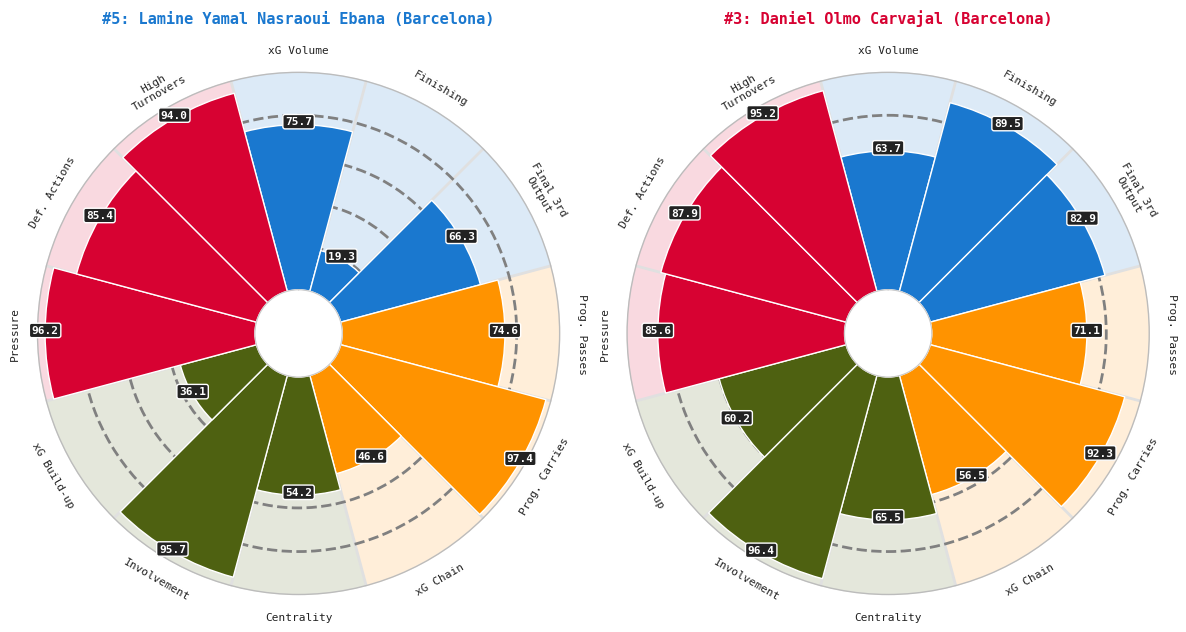

In [10]:
# Compare two top players
fig = visualization.plot_comparison_pizzas(
    player_scores_final, 
    p1_name=player_scores_final['player'][5], 
    p2_name=player_scores_final['player'][3],
    p1_rank=5, 
    p2_rank=3
)
save_figure(fig, 'player_comparison_pizzas.png')
plt.show()

2026 World Cup Readiness Model
What We Built
A data-driven scoring system that ranks national teams on their predicted readiness for the 2026 World Cup, combining player quality metrics, tactical context, and tournament-specific factors.
Player Quality (the foundation)
Each player in our database is scored on overall_quality — a composite metric built from position-adjusted performance data including progressive carries, xG chain involvement, network centrality, pressure success, and build-up contribution. Crucially, a defender's 80 and a forward's 80 mean the same thing — the score is already position-normalised, so we're comparing apples to apples across a full squad.
How Teams Are Scored
For each national team we match their declared roster against our player database and compute five components:
Squad Quality — the average overall_quality of matched players. Treated as an unbiased sample of the full squad's attacking and midfield strength.
Star Power — the average quality of the top 3 matched players, above a baseline threshold. This captures the ceiling of a team — the difference between a squad that can win on any given day versus one that's consistently good.
Manager Stability — a multiplier based on how long the current manager has been in charge. Longer tenure means more ingrained patterns, squad trust, and tactical cohesion. A manager appointed in 2020 scores higher than one appointed in 2025.
Club Cohesion — how many players at a national team share club teammates. Players who already play together daily require less time to build combinations and understanding at international level.
Recovery Edge — players based at North American clubs (MLS, Liga MX) have a travel and acclimatisation advantage as 2026 hosts. No long-haul flights, familiar stadiums, similar timezones.
Host nations (USA, Mexico, Canada) receive an additional bonus reflecting home crowd advantage and familiarity with venues.
Honest Limitations
Our player database of 272 players skews towards attackers and midfielders — this is inherent to xG-based data pipelines, which naturally capture offensive contribution better than defensive work. Defenders are underrepresented equally across all squads, so relative rankings remain valid, but the model is best interpreted as attacking and midfield readiness rather than complete squad quality.
Coverage varies by team — we typically match 4–8 players per squad, representing 20–45% of declared rosters. We surface this as Coverage_Pct in our output so readers can calibrate their confidence in each team's score accordingly.

,National_Team,Readiness_Score,Archetype,Archetype_Bonus,Squad_Quality,Star_Power,Stability,Manager_Tenure,Cohesion,Recovery,Travel_Penalty,Confederation,Host_Adv,Players_Found,Squad_Size,Coverage_Pct
0,France,76.42,Elite Dominators,1.31,67.57,4.01,1.05,14,2.65,0.00,2.5,UEFA,No,7,22,31.8
1,Spain,72.68,Conservative Pressers,0.65,69.01,4.10,0.98,4,2.80,0.00,2.5,UEFA,No,5,24,20.8
2,Germany,70.23,Elite Dominators,1.31,66.34,5.08,0.96,3,2.65,0.00,2.5,UEFA,No,7,23,30.4
3,Argentina,66.98,Elite Dominators,1.31,60.26,1.62,1.05,8,1.56,0.21,1.0,CONMEBOL,No,8,24,33.3
4,Portugal,59.48,Elite Dominators,1.31,57.92,3.07,0.96,3,2.00,0.00,2.5,UEFA,No,5,23,21.7
5,Brazil,58.48,Elite Dominators,1.31,58.13,2.19,0.92,1,2.50,0.00,1.0,CONMEBOL,No,4,25,16.0
6,Netherlands,57.83,Pragmatic Builders,0.36,57.40,2.64,0.96,3,2.22,0.00,2.5,UEFA,No,6,23,26.1
7,England,57.19,Conservative Pressers,0.65,57.76,3.09,0.92,1,2.80,0.00,2.5,UEFA,No,5,23,21.7
8,Croatia,56.29,Elite Dominators,1.31,50.75,2.19,1.05,9,2.00,0.00,2.5,UEFA,No,5,23,21.7
9,Canada,56.26,Elite Dominators,1.31,58.19,1.25,0.94,2,0.00,0.00,0.0,CONCACAF,Yes,2,8,25.0


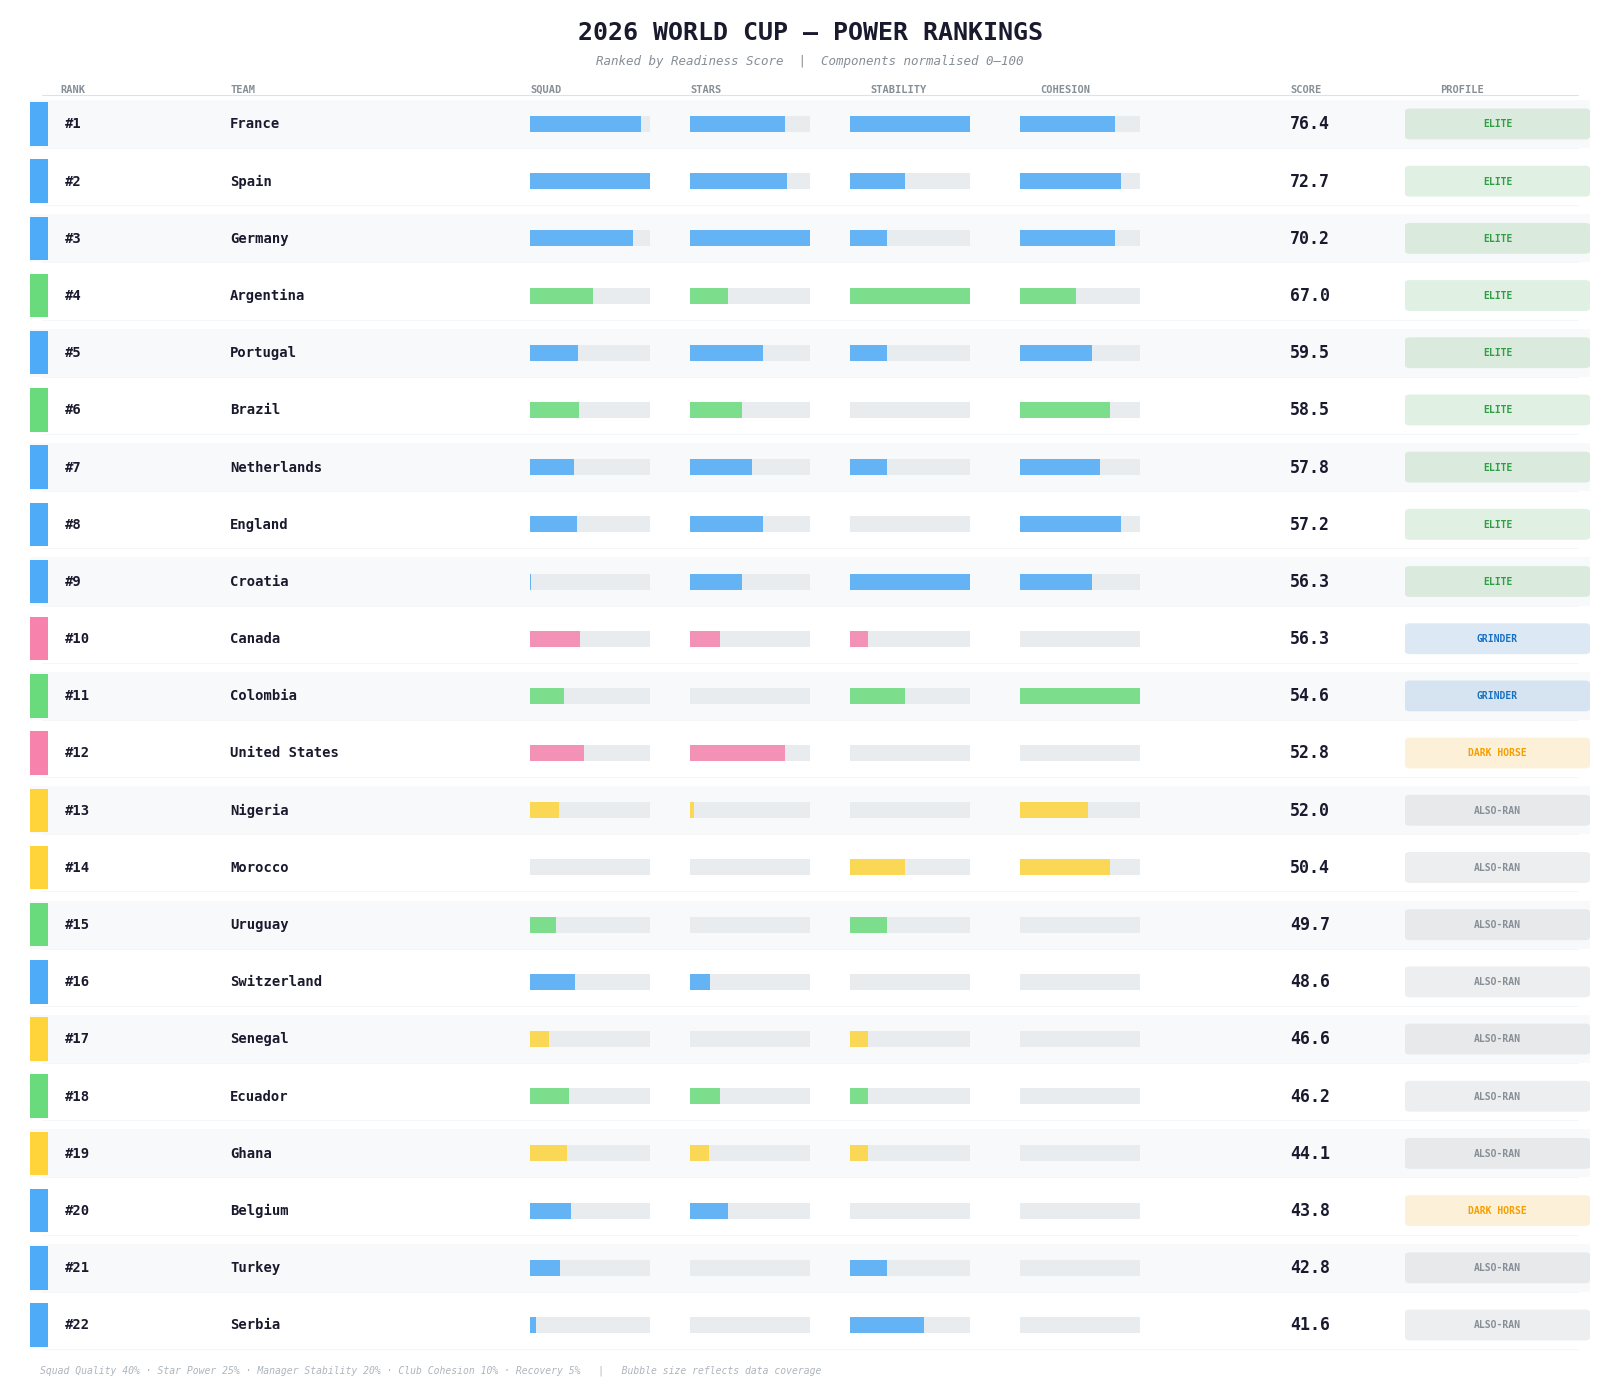

Saved: figures/wc2026_rankings.png


In [24]:
import wc2026_matchup
importlib.reload(wc2026_matchup)
from wc2026_matchup import *

final_rankings = run_system_fit_engine(
    player_scores_final,
    team_success,
    archetype_success,
    rosters_2026,
    CLUB_MAPPING_2026,
    MANAGER_TENURE,
)

display(final_rankings)

plot_power_rankings(final_rankings)

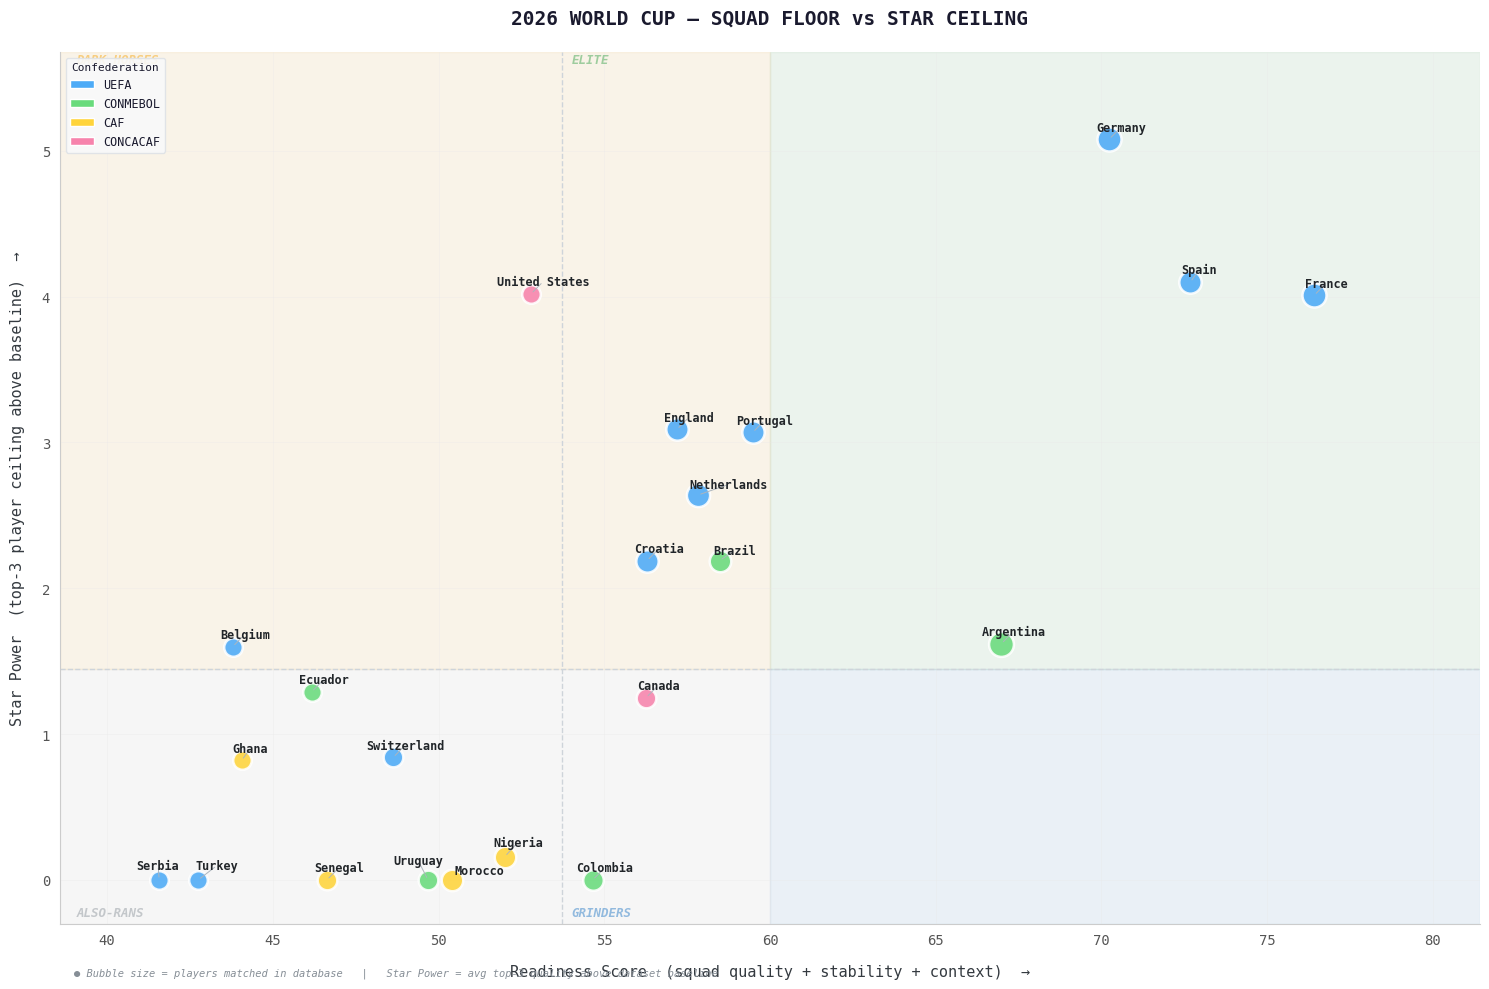

Saved: figures/wc2026_quadrant.png


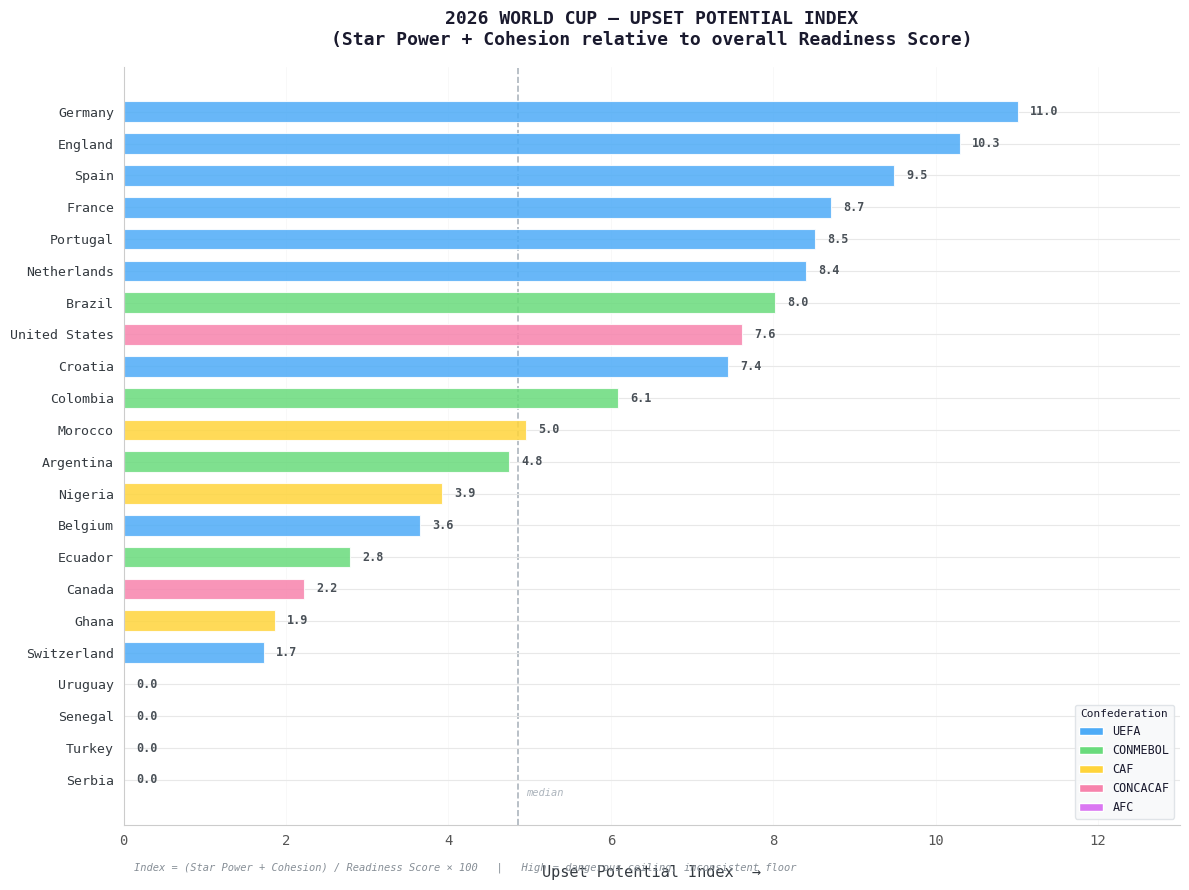

Saved: figures/wc2026_upset.png


,National_Team,Upset_Index,Star_Power,Cohesion,Readiness_Score
0,Germany,11.01,5.08,2.65,70.23
1,England,10.30,3.09,2.80,57.19
2,Spain,9.49,4.10,2.80,72.68
3,France,8.71,4.01,2.65,76.42
4,Portugal,8.52,3.07,2.00,59.48
5,Netherlands,8.40,2.64,2.22,57.83
6,Brazil,8.02,2.19,2.50,58.48
7,United States,7.62,4.02,0.00,52.79
8,Croatia,7.44,2.19,2.00,56.29
9,Colombia,6.09,0.00,3.33,54.65


In [20]:

import visualization
importlib.reload(visualization)
from visualization import *

# Quadrant plot
plot_quadrant(final_rankings)
# Upset potential
plot_upset_index(final_rankings)
# See the index as a table too
compute_upset_index(final_rankings)[['National_Team', 'Upset_Index', 'Star_Power', 'Cohesion', 'Readiness_Score']]

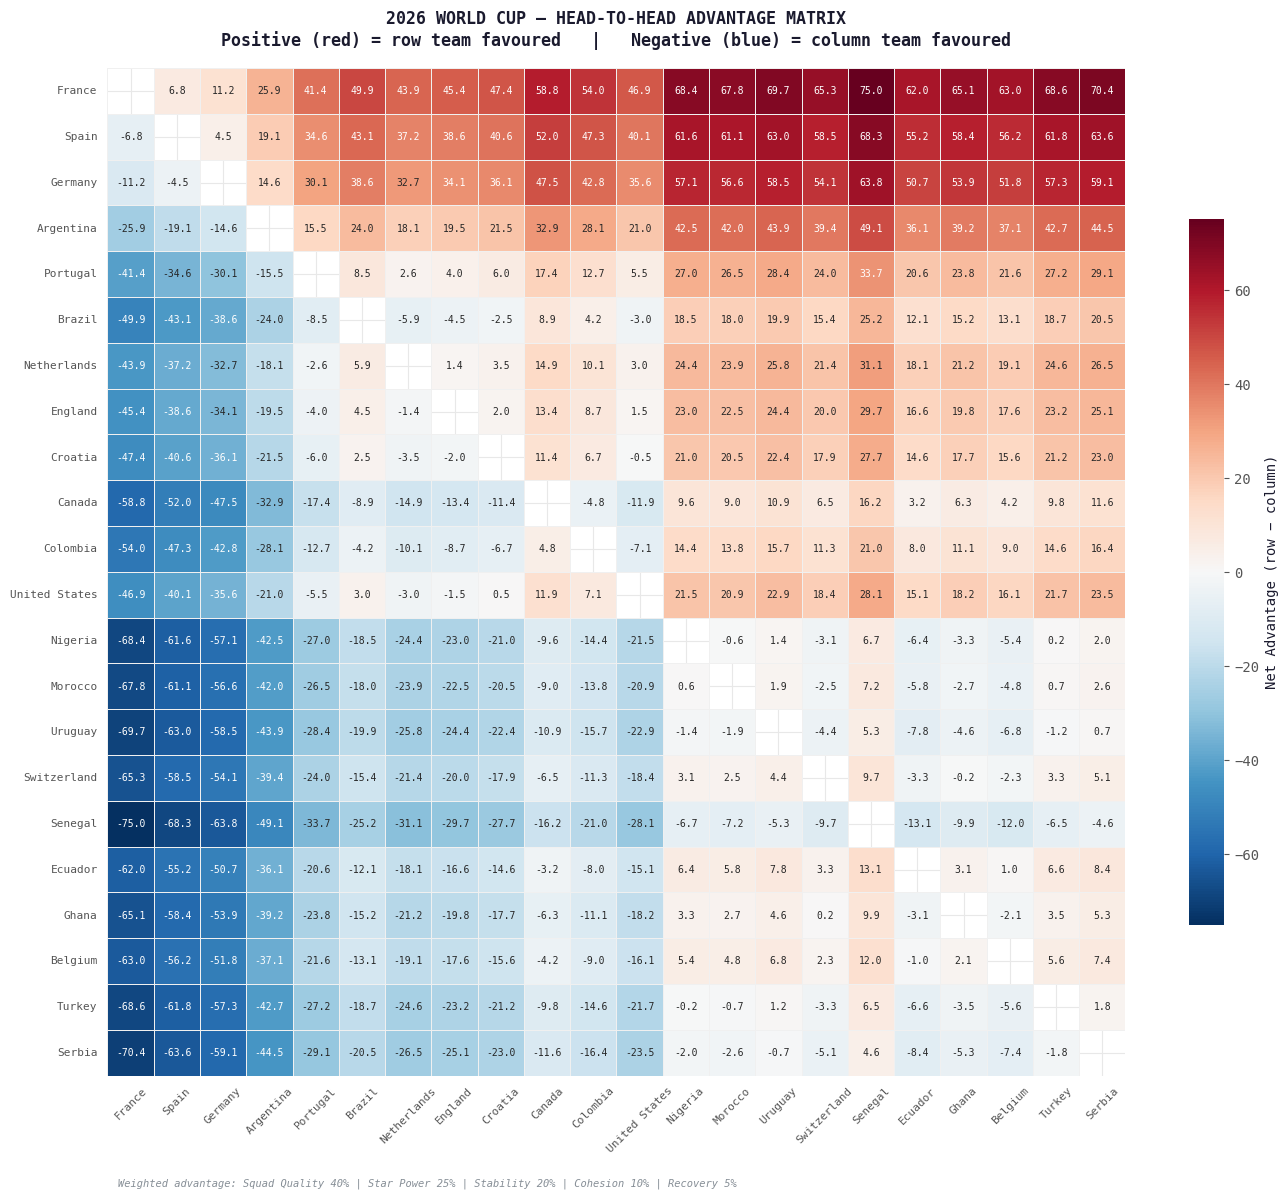

Saved: figures/wc2026_matchup_heatmap.png


In [ ]:
plot_matchup_heatmap(final_rankings)